In [37]:
import aiohttp
import asyncio
import nest_asyncio
from tqdm import tqdm
from tqdm.asyncio import tqdm_asyncio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import joblib
import os
import time
import json

pd.set_option('future.no_silent_downcasting', True)

## Extract data from json

In [2]:
nest_asyncio.apply()

In [ ]:
CHECKPOINT_FILE = 'checkpoint.pkl'
CHUNK_SIZE = 100  # Save checkpoint every 100 users processed
API_KEY = ""
REQUEST_TIMEOUT = 30 # seconds timeout for each API call

In [7]:
with open(r"..\..\assets\SteamWeb\steam_countries.json", "r", encoding="utf-8") as f:
    location_mapping = json.load(f)

with open(r"..\..\assets\SteamWeb\all_data_users.json", 'r') as f:
    data = json.load(f)

len(data)

14079

In [ ]:
def save_checkpoint(rows, processed_count):
    with open(CHECKPOINT_FILE, 'wb') as f:
        pickle.dump((rows, processed_count), f)
    print(f"Checkpoint saved at user index: {processed_count}")

def load_checkpoint():
    if os.path.exists(CHECKPOINT_FILE):
        with open(CHECKPOINT_FILE, 'rb') as f:
            rows, processed_count = pickle.load(f)
        print(f"Loaded checkpoint from user index: {processed_count}")
        return rows, processed_count
    else:
        return [], 0

In [ ]:
def get_coordinates(location_mapping, country_code, state_code, city_id):
    """
    Given the location mapping dictionary and location codes, return the coordinate string.
    """
    try:
        country = location_mapping.get(country_code)
        if not country:
            return None
        
        # Try state level if available.
        states = country.get("states", {})
        state = states.get(state_code) if state_code else None
        
        # If a city_id is provided and state exists, try city-level coordinates.
        if state and city_id is not None:
            cities = state.get("cities", {})
            city = cities.get(str(city_id))
            if city and city.get("coordinates"):
                return city.get("coordinates")
        
        # If city-level coordinates aren't found, try state-level coordinates.
        if state and state.get("coordinates"):
            return state.get("coordinates")
        
        # Finally, if state-level is not available, try country-level coordinates.
        if country.get("coordinates"):
            return country.get("coordinates")
        
        return None
    except Exception as e:
        print(f"Error mapping coordinates: {e}")
        return None

In [ ]:
async def get_player_achievements_async(session, user_id, app_id, api_key=API_KEY, rate_limit_flag=None):
    """
    Asynchronously get the total number of achievements for a user in a game.
    """
    url = "http://api.steampowered.com/ISteamUserStats/GetPlayerAchievements/v1/"
    params = {
        "key": api_key,
        "steamid": user_id,
        "appid": app_id
    }
    try:
        async with session.get(url, params=params) as response:
            if response.status == 429:
                if rate_limit_flag is not None and not rate_limit_flag.get('printed', False):
                    print(f"Rate limit reached for user {user_id} and game {app_id}. Waiting 60 seconds...")
                    rate_limit_flag['printed'] = True
                await asyncio.sleep(60)
                return await get_player_achievements_async(session, user_id, app_id, api_key, rate_limit_flag)
            elif response.status != 200:
                return None
            
            data = await response.json()
            
            if "playerstats" in data and "achievements" in data["playerstats"]:
                achievements = data["playerstats"]["achievements"]
                total_achieved = sum(1 for achievement in achievements if achievement.get("achieved", 0) == 1)
                return total_achieved
            else:
                return None
    except Exception as e:
        print(f"Error processing user {user_id} for game {app_id}: {e}")
        return None

In [8]:
async def safe_get_player_achievements_async(session, user_id, app_id, api_key, rate_limit_flag, timeout, timeout_flag=None):
    """
    Wraps get_player_achievements_async with a timeout.
    If the call exceeds the timeout, prints a single message per user and returns None.
    """
    try:
        return await asyncio.wait_for(
            get_player_achievements_async(session, user_id, app_id, api_key, rate_limit_flag),
            timeout=timeout
        )
    except asyncio.TimeoutError:
        if timeout_flag is not None and not timeout_flag.get('printed', False):
            print(f"Timeout reached for user {user_id}. Skipping request(s) for one or more games.")
            timeout_flag['printed'] = True
        return None

In [ ]:
async def process_users(data, location_mapping):
    """
    Process users asynchronously.
    For each user, get achievements for all owned games concurrently.
    Saves checkpoints every CHUNK_SIZE users.
    """
    rows, start_index = load_checkpoint()
    user_ids = list(data.keys())
    
    async with aiohttp.ClientSession() as session:
        # Outer loop wrapped with a progress bar.
        for idx, user_id in enumerate(tqdm(user_ids[start_index:], initial=start_index, total=len(user_ids)), start=start_index):
            user_info = data[user_id]
            timecreated = user_info.get('timecreated')
            locCountryCode = user_info.get("locCountryCode")
            locStateCode = user_info.get("locStateCode")
            locCityID = user_info.get("locCityID")
            
            coordinates = get_coordinates(location_mapping, locCountryCode, locStateCode, locCityID) if locCountryCode else None

            owned_games = user_info.get('owned_games', [])
            if not owned_games:
                continue

            # Create shared flags for this user's tasks.
            rate_limit_flag = {'printed': False}
            timeout_flag = {'printed': False}
            
            # Create asynchronous tasks with timeout for each game.
            tasks = [
                safe_get_player_achievements_async(session, user_id, game.get('appid'),
                                                   API_KEY, rate_limit_flag, REQUEST_TIMEOUT, timeout_flag)
                for game in owned_games
            ]
            
            # Run tasks concurrently.
            achievements_list = await asyncio.gather(*tasks)
            
            # Build rows with the obtained achievements.
            for game, achievements in zip(owned_games, achievements_list):
                row = {
                    'user_id': user_id,
                    'app_id': game.get('appid'),
                    'playtime_forever': game.get('playtime_forever', 0),
                    'timeCreated': timecreated,
                    'locCountryCode': locCountryCode,
                    'locStateCode': locStateCode,
                    'locCityID': locCityID,
                    'coordinates': coordinates,
                    'achievements': achievements
                }
                rows.append(row)
            
            # Save a checkpoint every CHUNK_SIZE users processed.
            if (idx + 1) % CHUNK_SIZE == 0:
                save_checkpoint(rows, idx + 1)
    
    # Final checkpoint after processing all users.
    save_checkpoint(rows, len(user_ids))
    return rows

In [10]:
rows = asyncio.run(process_users(data, location_mapping))

Loaded checkpoint from user index: 900


  7%|▋         | 930/14079 [01:03<9:10:03,  2.51s/it] 

Timeout reached for user 76561198020810038. Skipping request(s) for one or more games.


  7%|▋         | 1002/14079 [04:59<27:45:05,  7.64s/it]

Timeout reached for user 76561198005092460. Skipping request(s) for one or more games.


  7%|▋         | 1034/14079 [06:16<35:55:29,  9.91s/it]

Timeout reached for user 76561198119034033. Skipping request(s) for one or more games.


  7%|▋         | 1050/14079 [07:05<19:58:07,  5.52s/it]

Timeout reached for user 76561198090285848. Skipping request(s) for one or more games.


  8%|▊         | 1056/14079 [07:49<34:56:35,  9.66s/it]

Timeout reached for user 76561197974105151. Skipping request(s) for one or more games.


  8%|▊         | 1068/14079 [08:31<11:25:59,  3.16s/it]

Rate limit reached for user 76561198029028690 and game 1904610. Waiting 60 seconds...


  8%|▊         | 1070/14079 [09:02<25:45:13,  7.13s/it]

Timeout reached for user 76561198029028690. Skipping request(s) for one or more games.


  8%|▊         | 1071/14079 [09:33<42:20:48, 11.72s/it]

Timeout reached for user 76561197976469696. Skipping request(s) for one or more games.
Timeout reached for user 76561198141345700. Skipping request(s) for one or more games.


  8%|▊         | 1092/14079 [11:16<36:55:37, 10.24s/it]

Timeout reached for user 76561198062248931. Skipping request(s) for one or more games.


  8%|▊         | 1099/14079 [11:40<13:38:49,  3.79s/it]

Timeout reached for user 76561197969878452. Skipping request(s) for one or more games.


  8%|▊         | 1113/14079 [12:59<29:39:24,  8.23s/it]

Timeout reached for user 76561198130500709. Skipping request(s) for one or more games.


  8%|▊         | 1121/14079 [13:36<22:12:35,  6.17s/it]

Timeout reached for user 76561198051464491. Skipping request(s) for one or more games.
Rate limit reached for user 76561198059745288 and game 459830. Waiting 60 seconds...
Timeout reached for user 76561198059745288. Skipping request(s) for one or more games.


  8%|▊         | 1123/14079 [14:38<52:11:32, 14.50s/it]

Timeout reached for user 76561198052425828. Skipping request(s) for one or more games.


  8%|▊         | 1131/14079 [14:44<10:54:15,  3.03s/it]

Rate limit reached for user 76561197997731390 and game 447850. Waiting 60 seconds...


  8%|▊         | 1133/14079 [15:15<23:44:11,  6.60s/it]

Timeout reached for user 76561197997731390. Skipping request(s) for one or more games.


  8%|▊         | 1146/14079 [16:00<21:21:37,  5.95s/it]

Timeout reached for user 76561198109429966. Skipping request(s) for one or more games.


  8%|▊         | 1161/14079 [16:47<23:49:44,  6.64s/it]

Timeout reached for user 76561198078615370. Skipping request(s) for one or more games.


  8%|▊         | 1165/14079 [17:25<39:43:24, 11.07s/it]

Timeout reached for user 76561198077679148. Skipping request(s) for one or more games.


  8%|▊         | 1171/14079 [18:05<30:15:45,  8.44s/it]

Timeout reached for user 76561197992567492. Skipping request(s) for one or more games.


  8%|▊         | 1178/14079 [18:39<28:07:56,  7.85s/it]

Timeout reached for user 76561198043457076. Skipping request(s) for one or more games.


  9%|▊         | 1207/14079 [20:30<29:46:54,  8.33s/it]

Timeout reached for user 76561198022639844. Skipping request(s) for one or more games.


  9%|▊         | 1216/14079 [21:25<30:03:38,  8.41s/it]

Timeout reached for user 76561198416430564. Skipping request(s) for one or more games.


  9%|▊         | 1221/14079 [22:03<31:08:23,  8.72s/it]

Timeout reached for user 76561198048179892. Skipping request(s) for one or more games.


  9%|▊         | 1228/14079 [22:23<17:29:12,  4.90s/it]

Timeout reached for user 76561198018018544. Skipping request(s) for one or more games.


  9%|▉         | 1235/14079 [23:38<45:00:19, 12.61s/it]

Timeout reached for user 76561198032807524. Skipping request(s) for one or more games.


  9%|▉         | 1238/14079 [24:22<54:53:04, 15.39s/it]

Timeout reached for user 76561198074734500. Skipping request(s) for one or more games.


  9%|▉         | 1256/14079 [25:08<21:04:36,  5.92s/it]

Timeout reached for user 76561198058345044. Skipping request(s) for one or more games.


  9%|▉         | 1258/14079 [25:40<37:06:34, 10.42s/it]

Timeout reached for user 76561198083528870. Skipping request(s) for one or more games.


  9%|▉         | 1281/14079 [27:07<24:37:23,  6.93s/it]

Timeout reached for user 76561198065044951. Skipping request(s) for one or more games.


  9%|▉         | 1282/14079 [27:10<22:01:15,  6.19s/it]

Timeout reached for user 76561198031255971. Skipping request(s) for one or more games.


  9%|▉         | 1290/14079 [28:13<22:46:55,  6.41s/it]

Timeout reached for user 76561197975191111. Skipping request(s) for one or more games.


  9%|▉         | 1300/14079 [28:26<6:30:39,  1.83s/it] 

Checkpoint saved at user index: 1300


  9%|▉         | 1307/14079 [29:11<38:26:29, 10.84s/it]

Timeout reached for user 76561198069261169. Skipping request(s) for one or more games.


  9%|▉         | 1323/14079 [29:51<8:01:30,  2.26s/it] 

Timeout reached for user 76561198120266850. Skipping request(s) for one or more games.


  9%|▉         | 1326/14079 [30:52<37:12:52, 10.51s/it]

Timeout reached for user 76561198013009503. Skipping request(s) for one or more games.


  9%|▉         | 1334/14079 [31:24<22:23:07,  6.32s/it]

Timeout reached for user 76561198095365060. Skipping request(s) for one or more games.


 10%|▉         | 1359/14079 [33:07<27:49:45,  7.88s/it]

Timeout reached for user 76561198056261703. Skipping request(s) for one or more games.


 10%|▉         | 1361/14079 [33:15<23:38:43,  6.69s/it]

Timeout reached for user 76561197967599040. Skipping request(s) for one or more games.


 10%|▉         | 1371/14079 [34:53<40:08:58, 11.37s/it]

Timeout reached for user 76561198063410932. Skipping request(s) for one or more games.


 10%|▉         | 1386/14079 [35:42<27:44:18,  7.87s/it]

Timeout reached for user 76561197993722998. Skipping request(s) for one or more games.


 10%|█         | 1424/14079 [36:28<3:06:17,  1.13it/s] 

Rate limit reached for user 76561197993652683 and game 375960. Waiting 60 seconds...
Timeout reached for user 76561197993652683. Skipping request(s) for one or more games.


 10%|█         | 1426/14079 [36:59<18:57:44,  5.40s/it]

Rate limit reached for user 76561198035641989 and game 115210. Waiting 60 seconds...


 10%|█         | 1427/14079 [37:29<34:32:57,  9.83s/it]

Timeout reached for user 76561198035641989. Skipping request(s) for one or more games.


 10%|█         | 1439/14079 [38:44<34:39:40,  9.87s/it]

Timeout reached for user 76561197989314131. Skipping request(s) for one or more games.


 10%|█         | 1446/14079 [39:19<22:47:11,  6.49s/it]

Timeout reached for user 76561197966494103. Skipping request(s) for one or more games.


 10%|█         | 1458/14079 [40:05<18:34:14,  5.30s/it]

Timeout reached for user 76561198416402644. Skipping request(s) for one or more games.


 10%|█         | 1460/14079 [40:38<33:12:25,  9.47s/it]

Timeout reached for user 76561197960272407. Skipping request(s) for one or more games.


 10%|█         | 1462/14079 [41:08<39:42:15, 11.33s/it]

Timeout reached for user 76561198063414036. Skipping request(s) for one or more games.


 10%|█         | 1471/14079 [42:06<27:55:41,  7.97s/it]

Timeout reached for user 76561197995534963. Skipping request(s) for one or more games.


 10%|█         | 1474/14079 [42:56<43:43:44, 12.49s/it]

Timeout reached for user 76561197973413013. Skipping request(s) for one or more games.


 11%|█         | 1480/14079 [43:44<41:41:19, 11.91s/it]

Timeout reached for user 76561198012454115. Skipping request(s) for one or more games.


 11%|█         | 1482/14079 [44:17<51:14:33, 14.64s/it]

Timeout reached for user 76561198021194980. Skipping request(s) for one or more games.


 11%|█         | 1498/14079 [44:59<17:07:29,  4.90s/it]

Timeout reached for user 76561197993525512. Skipping request(s) for one or more games.


 11%|█         | 1500/14079 [45:05<14:50:37,  4.25s/it]

Checkpoint saved at user index: 1500


 11%|█         | 1502/14079 [45:35<27:04:08,  7.75s/it]

Timeout reached for user 76561198042000024. Skipping request(s) for one or more games.


 11%|█         | 1509/14079 [46:15<29:09:43,  8.35s/it]

Timeout reached for user 76561198095027312. Skipping request(s) for one or more games.


 11%|█         | 1522/14079 [46:31<6:58:48,  2.00s/it] 

Timeout reached for user 76561198046423728. Skipping request(s) for one or more games.


 11%|█         | 1529/14079 [47:55<35:33:07, 10.20s/it]

Timeout reached for user 76561197990197813. Skipping request(s) for one or more games.


 11%|█         | 1545/14079 [49:37<31:58:49,  9.19s/it]

Timeout reached for user 76561198047554260. Skipping request(s) for one or more games.


 11%|█         | 1547/14079 [50:08<44:49:54, 12.88s/it]

Timeout reached for user 76561198066836630. Skipping request(s) for one or more games.


 11%|█         | 1552/14079 [50:43<33:34:27,  9.65s/it]

Timeout reached for user 76561198031149724. Skipping request(s) for one or more games.


 11%|█         | 1557/14079 [51:16<31:28:39,  9.05s/it]

Timeout reached for user 76561198041716928. Skipping request(s) for one or more games.


 11%|█         | 1561/14079 [51:50<33:51:27,  9.74s/it]

Timeout reached for user 76561197983311223. Skipping request(s) for one or more games.


 11%|█         | 1563/14079 [51:52<23:07:39,  6.65s/it]

Timeout reached for user 76561198339545040. Skipping request(s) for one or more games.


 11%|█▏        | 1593/14079 [54:20<31:18:55,  9.03s/it]

Timeout reached for user 76561198011015971. Skipping request(s) for one or more games.


 11%|█▏        | 1600/14079 [55:16<35:44:48, 10.31s/it]

Checkpoint saved at user index: 1600


 11%|█▏        | 1611/14079 [56:19<28:19:05,  8.18s/it]

Timeout reached for user 76561198053093956. Skipping request(s) for one or more games.


 12%|█▏        | 1623/14079 [57:05<25:11:01,  7.28s/it]

Timeout reached for user 76561197960887011. Skipping request(s) for one or more games.


 12%|█▏        | 1624/14079 [57:35<41:43:00, 12.06s/it]

Timeout reached for user 76561198039576319. Skipping request(s) for one or more games.


 12%|█▏        | 1627/14079 [58:08<43:50:56, 12.68s/it]

Timeout reached for user 76561197960545306. Skipping request(s) for one or more games.


 12%|█▏        | 1631/14079 [58:43<41:19:56, 11.95s/it]

Timeout reached for user 76561198043804384. Skipping request(s) for one or more games.


 12%|█▏        | 1634/14079 [59:14<38:30:00, 11.14s/it]

Timeout reached for user 76561198017452124. Skipping request(s) for one or more games.


 12%|█▏        | 1644/14079 [1:00:16<33:24:47,  9.67s/it]

Timeout reached for user 76561198007700826. Skipping request(s) for one or more games.


 12%|█▏        | 1648/14079 [1:00:18<16:19:25,  4.73s/it]

Timeout reached for user 76561197999760304. Skipping request(s) for one or more games.


 12%|█▏        | 1651/14079 [1:01:19<39:21:56, 11.40s/it]

Timeout reached for user 76561198031438867. Skipping request(s) for one or more games.


 12%|█▏        | 1659/14079 [1:02:01<34:48:52, 10.09s/it]

Timeout reached for user 76561198031289034. Skipping request(s) for one or more games.


 12%|█▏        | 1675/14079 [1:03:06<26:05:43,  7.57s/it]

Timeout reached for user 76561198025776808. Skipping request(s) for one or more games.


 12%|█▏        | 1676/14079 [1:03:36<43:46:00, 12.70s/it]

Timeout reached for user 76561198052636148. Skipping request(s) for one or more games.


 12%|█▏        | 1688/14079 [1:04:24<23:08:30,  6.72s/it]

Timeout reached for user 76561198097203733. Skipping request(s) for one or more games.


 12%|█▏        | 1699/14079 [1:04:45<7:19:11,  2.13s/it] 

Timeout reached for user 76561197983524304. Skipping request(s) for one or more games.


 12%|█▏        | 1700/14079 [1:05:17<27:47:54,  8.08s/it]

Checkpoint saved at user index: 1700


 12%|█▏        | 1701/14079 [1:05:47<44:47:11, 13.03s/it]

Timeout reached for user 76561198014604671. Skipping request(s) for one or more games.


 12%|█▏        | 1704/14079 [1:06:01<29:58:35,  8.72s/it]

Timeout reached for user 76561197994153029. Skipping request(s) for one or more games.


 12%|█▏        | 1709/14079 [1:07:07<46:33:53, 13.55s/it]

Timeout reached for user 76561198025505604. Skipping request(s) for one or more games.


 12%|█▏        | 1729/14079 [1:07:58<16:24:16,  4.78s/it]

Timeout reached for user 76561198120719806. Skipping request(s) for one or more games.


 12%|█▏        | 1730/14079 [1:08:28<30:38:56,  8.93s/it]

Timeout reached for user 76561198416089492. Skipping request(s) for one or more games.


 12%|█▏        | 1737/14079 [1:08:41<10:21:14,  3.02s/it]

Timeout reached for user 76561197971373352. Skipping request(s) for one or more games.


 12%|█▏        | 1742/14079 [1:09:22<18:14:58,  5.33s/it]

Rate limit reached for user 76561198018264414 and game 645460. Waiting 60 seconds...


 12%|█▏        | 1743/14079 [1:09:52<36:21:08, 10.61s/it]

Timeout reached for user 76561198018264414. Skipping request(s) for one or more games.


 12%|█▏        | 1751/14079 [1:10:52<28:44:20,  8.39s/it]

Timeout reached for user 76561198023007646. Skipping request(s) for one or more games.


 13%|█▎        | 1765/14079 [1:12:01<27:00:03,  7.89s/it]

Timeout reached for user 76561198082529788. Skipping request(s) for one or more games.


 13%|█▎        | 1772/14079 [1:12:39<26:55:56,  7.88s/it]

Timeout reached for user 76561198416434596. Skipping request(s) for one or more games.


 13%|█▎        | 1782/14079 [1:13:19<23:15:17,  6.81s/it]

Timeout reached for user 76561198084597941. Skipping request(s) for one or more games.


 13%|█▎        | 1785/14079 [1:13:52<31:29:31,  9.22s/it]

Timeout reached for user 76561198025559748. Skipping request(s) for one or more games.


 13%|█▎        | 1787/14079 [1:14:24<43:58:20, 12.88s/it]

Timeout reached for user 76561198019839251. Skipping request(s) for one or more games.


 13%|█▎        | 1791/14079 [1:14:59<39:42:14, 11.63s/it]

Timeout reached for user 76561198002179057. Skipping request(s) for one or more games.


 13%|█▎        | 1801/14079 [1:15:41<20:53:06,  6.12s/it]

Timeout reached for user 76561198038491354. Skipping request(s) for one or more games.


 13%|█▎        | 1808/14079 [1:16:14<22:33:31,  6.62s/it]

Timeout reached for user 76561198025882370. Skipping request(s) for one or more games.


 13%|█▎        | 1813/14079 [1:16:50<27:22:02,  8.03s/it]

Timeout reached for user 76561198019905799. Skipping request(s) for one or more games.


 13%|█▎        | 1815/14079 [1:17:20<35:07:13, 10.31s/it]

Timeout reached for user 76561197964223124. Skipping request(s) for one or more games.


 13%|█▎        | 1816/14079 [1:17:51<48:24:24, 14.21s/it]

Timeout reached for user 76561198035226548. Skipping request(s) for one or more games.


 13%|█▎        | 1821/14079 [1:18:21<32:20:22,  9.50s/it]

Timeout reached for user 76561198026855717. Skipping request(s) for one or more games.


 13%|█▎        | 1822/14079 [1:18:52<42:37:40, 12.52s/it]

Timeout reached for user 76561198066373525. Skipping request(s) for one or more games.


 13%|█▎        | 1849/14079 [1:20:11<17:27:08,  5.14s/it]

Timeout reached for user 76561197972468900. Skipping request(s) for one or more games.


 13%|█▎        | 1884/14079 [1:22:05<16:30:43,  4.87s/it]

Timeout reached for user 76561197996043956. Skipping request(s) for one or more games.


 13%|█▎        | 1899/14079 [1:22:46<18:30:44,  5.47s/it]

Timeout reached for user 76561198028132676. Skipping request(s) for one or more games.


 14%|█▎        | 1908/14079 [1:23:24<23:36:54,  6.98s/it]

Timeout reached for user 76561198180024173. Skipping request(s) for one or more games.


 14%|█▎        | 1911/14079 [1:23:58<36:59:34, 10.94s/it]

Timeout reached for user 76561198058830724. Skipping request(s) for one or more games.


 14%|█▎        | 1912/14079 [1:23:59<28:36:46,  8.47s/it]

Timeout reached for user 76561198070220549. Skipping request(s) for one or more games.


 14%|█▎        | 1916/14079 [1:25:04<43:56:50, 13.01s/it]

Timeout reached for user 76561198027188973. Skipping request(s) for one or more games.


 14%|█▍        | 1955/14079 [1:26:16<25:14:05,  7.49s/it]

Timeout reached for user 76561198002223588. Skipping request(s) for one or more games.


 14%|█▍        | 1970/14079 [1:27:10<26:45:54,  7.96s/it]

Timeout reached for user 76561197977752897. Skipping request(s) for one or more games.


 14%|█▍        | 1975/14079 [1:27:47<34:19:24, 10.21s/it]

Timeout reached for user 76561197970806724. Skipping request(s) for one or more games.


 14%|█▍        | 1981/14079 [1:28:53<42:12:31, 12.56s/it]

Timeout reached for user 76561198088855866. Skipping request(s) for one or more games.


 14%|█▍        | 1990/14079 [1:29:57<31:58:25,  9.52s/it]

Timeout reached for user 76561198055087944. Skipping request(s) for one or more games.


 14%|█▍        | 1996/14079 [1:30:41<33:15:17,  9.91s/it]

Timeout reached for user 76561197995232038. Skipping request(s) for one or more games.


 14%|█▍        | 2001/14079 [1:30:44<10:27:58,  3.12s/it]

Timeout reached for user 76561197962290563. Skipping request(s) for one or more games.


 14%|█▍        | 2016/14079 [1:32:00<21:20:20,  6.37s/it]

Timeout reached for user 76561198023118500. Skipping request(s) for one or more games.


 14%|█▍        | 2018/14079 [1:32:31<35:47:28, 10.68s/it]

Timeout reached for user 76561198075821988. Skipping request(s) for one or more games.


 14%|█▍        | 2023/14079 [1:33:01<26:20:15,  7.86s/it]

Timeout reached for user 76561198417727619. Skipping request(s) for one or more games.


 14%|█▍        | 2025/14079 [1:33:36<38:05:02, 11.37s/it]

Timeout reached for user 76561198018400550. Skipping request(s) for one or more games.


 14%|█▍        | 2031/14079 [1:34:12<26:07:37,  7.81s/it]

Timeout reached for user 76561197985943650. Skipping request(s) for one or more games.


 14%|█▍        | 2032/14079 [1:34:42<38:29:04, 11.50s/it]

Timeout reached for user 76561198011333988. Skipping request(s) for one or more games.


 14%|█▍        | 2033/14079 [1:35:12<50:22:21, 15.05s/it]

Timeout reached for user 76561198106622136. Skipping request(s) for one or more games.


 15%|█▍        | 2067/14079 [1:36:38<15:05:12,  4.52s/it]

Timeout reached for user 76561197981532133. Skipping request(s) for one or more games.


 15%|█▍        | 2068/14079 [1:37:08<28:02:12,  8.40s/it]

Timeout reached for user 76561198415872597. Skipping request(s) for one or more games.


 15%|█▍        | 2073/14079 [1:37:41<29:50:04,  8.95s/it]

Timeout reached for user 76561198028226338. Skipping request(s) for one or more games.


 15%|█▍        | 2089/14079 [1:38:37<28:43:34,  8.63s/it]

Timeout reached for user 76561197970351665. Skipping request(s) for one or more games.


 15%|█▍        | 2098/14079 [1:39:30<25:54:48,  7.79s/it]

Timeout reached for user 76561197988047028. Skipping request(s) for one or more games.


 15%|█▍        | 2100/14079 [1:39:31<17:59:16,  5.41s/it]

Checkpoint saved at user index: 2100


 15%|█▍        | 2105/14079 [1:40:20<34:38:11, 10.41s/it]

Timeout reached for user 76561197975866843. Skipping request(s) for one or more games.


 15%|█▍        | 2107/14079 [1:40:52<46:14:47, 13.91s/it]

Timeout reached for user 76561198067418244. Skipping request(s) for one or more games.


 15%|█▌        | 2129/14079 [1:41:39<13:54:36,  4.19s/it]

Timeout reached for user 76561198006423188. Skipping request(s) for one or more games.


 15%|█▌        | 2141/14079 [1:42:54<47:59:45, 14.47s/it]

Timeout reached for user 76561198122943652. Skipping request(s) for one or more games.


 15%|█▌        | 2150/14079 [1:43:05<10:31:50,  3.18s/it]

Timeout reached for user 76561198009676887. Skipping request(s) for one or more games.


 15%|█▌        | 2168/14079 [1:44:40<27:44:49,  8.39s/it]

Timeout reached for user 76561197998430836. Skipping request(s) for one or more games.


 15%|█▌        | 2171/14079 [1:45:15<40:35:21, 12.27s/it]

Timeout reached for user 76561198011816896. Skipping request(s) for one or more games.


 16%|█▌        | 2199/14079 [1:46:09<12:01:43,  3.65s/it]

Timeout reached for user 76561198037830999. Skipping request(s) for one or more games.


 16%|█▌        | 2200/14079 [1:46:39<28:09:58,  8.54s/it]

Checkpoint saved at user index: 2200


 16%|█▌        | 2221/14079 [1:47:35<12:04:36,  3.67s/it]

Timeout reached for user 76561197980590342. Skipping request(s) for one or more games.


 16%|█▌        | 2223/14079 [1:48:07<24:14:49,  7.36s/it]

Timeout reached for user 76561198019324737. Skipping request(s) for one or more games.


 16%|█▌        | 2231/14079 [1:48:16<8:51:37,  2.69s/it] 

Timeout reached for user 76561197974007233. Skipping request(s) for one or more games.


 16%|█▌        | 2237/14079 [1:49:25<31:18:40,  9.52s/it]

Timeout reached for user 76561198416231476. Skipping request(s) for one or more games.


 16%|█▌        | 2246/14079 [1:50:04<28:49:57,  8.77s/it]

Timeout reached for user 76561198030081746. Skipping request(s) for one or more games.


 16%|█▌        | 2261/14079 [1:50:47<26:19:38,  8.02s/it]

Timeout reached for user 76561198062887863. Skipping request(s) for one or more games.


 16%|█▌        | 2263/14079 [1:51:17<35:28:22, 10.81s/it]

Timeout reached for user 76561198001627904. Skipping request(s) for one or more games.


 16%|█▌        | 2268/14079 [1:51:48<26:23:55,  8.05s/it]

Timeout reached for user 76561198107441026. Skipping request(s) for one or more games.


 16%|█▋        | 2299/14079 [1:52:55<22:57:17,  7.02s/it]

Timeout reached for user 76561198416807396. Skipping request(s) for one or more games.


 16%|█▋        | 2315/14079 [1:53:43<24:42:03,  7.56s/it]

Timeout reached for user 76561198015459661. Skipping request(s) for one or more games.


 16%|█▋        | 2320/14079 [1:54:29<36:18:49, 11.12s/it]

Timeout reached for user 76561198008335925. Skipping request(s) for one or more games.


 17%|█▋        | 2331/14079 [1:55:03<24:12:11,  7.42s/it]

Timeout reached for user 76561198115809507. Skipping request(s) for one or more games.


 17%|█▋        | 2342/14079 [1:55:49<25:25:02,  7.80s/it]

Timeout reached for user 76561197998465267. Skipping request(s) for one or more games.


 17%|█▋        | 2350/14079 [1:56:39<26:08:37,  8.02s/it]

Timeout reached for user 76561198039785193. Skipping request(s) for one or more games.


 17%|█▋        | 2367/14079 [1:57:39<28:44:22,  8.83s/it]

Timeout reached for user 76561198062544187. Skipping request(s) for one or more games.


 17%|█▋        | 2389/14079 [1:59:15<29:26:38,  9.07s/it]

Timeout reached for user 76561198416271796. Skipping request(s) for one or more games.


 17%|█▋        | 2400/14079 [1:59:40<9:15:40,  2.85s/it] 

Checkpoint saved at user index: 2400


 17%|█▋        | 2406/14079 [2:00:35<31:09:45,  9.61s/it]

Timeout reached for user 76561197994319568. Skipping request(s) for one or more games.


 17%|█▋        | 2416/14079 [2:01:34<27:20:25,  8.44s/it]

Timeout reached for user 76561198085034004. Skipping request(s) for one or more games.


 17%|█▋        | 2419/14079 [2:01:43<17:29:54,  5.40s/it]

Timeout reached for user 76561198031762613. Skipping request(s) for one or more games.


 17%|█▋        | 2443/14079 [2:03:22<20:33:06,  6.36s/it]

Timeout reached for user 76561198094389525. Skipping request(s) for one or more games.


 17%|█▋        | 2447/14079 [2:04:05<27:59:09,  8.66s/it]

Timeout reached for user 76561198059701300. Skipping request(s) for one or more games.


 18%|█▊        | 2466/14079 [2:04:54<16:54:10,  5.24s/it]

Timeout reached for user 76561198018543396. Skipping request(s) for one or more games.
Timeout reached for user 76561197980823956. Skipping request(s) for one or more games.


 18%|█▊        | 2479/14079 [2:06:27<22:37:21,  7.02s/it]

Timeout reached for user 76561198064747371. Skipping request(s) for one or more games.


 18%|█▊        | 2493/14079 [2:06:50<7:03:37,  2.19s/it] 

Timeout reached for user 76561198049905605. Skipping request(s) for one or more games.


 18%|█▊        | 2501/14079 [2:07:57<23:47:17,  7.40s/it]

Timeout reached for user 76561197991801348. Skipping request(s) for one or more games.


 18%|█▊        | 2502/14079 [2:08:27<36:05:01, 11.22s/it]

Timeout reached for user 76561198014577396. Skipping request(s) for one or more games.


 18%|█▊        | 2503/14079 [2:08:58<48:15:13, 15.01s/it]

Timeout reached for user 76561197978168874. Skipping request(s) for one or more games.


 18%|█▊        | 2523/14079 [2:09:49<17:14:53,  5.37s/it]

Timeout reached for user 76561197962487845. Skipping request(s) for one or more games.


 18%|█▊        | 2537/14079 [2:11:01<23:37:03,  7.37s/it]

Timeout reached for user 76561198081143800. Skipping request(s) for one or more games.


 18%|█▊        | 2568/14079 [2:12:17<8:46:09,  2.74s/it] 

Rate limit reached for user 76561197970359081 and game 551520. Waiting 60 seconds...
Timeout reached for user 76561197970359081. Skipping request(s) for one or more games.


 18%|█▊        | 2578/14079 [2:13:45<34:26:48, 10.78s/it]

Timeout reached for user 76561198072473688. Skipping request(s) for one or more games.


 18%|█▊        | 2586/14079 [2:14:23<29:32:03,  9.25s/it]

Timeout reached for user 76561197990899148. Skipping request(s) for one or more games.


 18%|█▊        | 2601/14079 [2:15:10<18:24:08,  5.77s/it]

Timeout reached for user 76561197998920990. Skipping request(s) for one or more games.


 18%|█▊        | 2603/14079 [2:15:40<27:33:26,  8.64s/it]

Timeout reached for user 76561198056695351. Skipping request(s) for one or more games.


 19%|█▊        | 2608/14079 [2:16:34<41:33:43, 13.04s/it]

Timeout reached for user 76561198068259362. Skipping request(s) for one or more games.


 19%|█▊        | 2616/14079 [2:17:14<30:03:14,  9.44s/it]

Timeout reached for user 76561198024383093. Skipping request(s) for one or more games.


 19%|█▊        | 2619/14079 [2:17:50<41:16:46, 12.97s/it]

Timeout reached for user 76561198063515404. Skipping request(s) for one or more games.


 19%|█▉        | 2647/14079 [2:18:57<21:53:11,  6.89s/it]

Timeout reached for user 76561197990209791. Skipping request(s) for one or more games.


 19%|█▉        | 2703/14079 [2:20:57<24:20:52,  7.71s/it]

Timeout reached for user 76561198006124438. Skipping request(s) for one or more games.


 19%|█▉        | 2716/14079 [2:21:58<25:00:10,  7.92s/it]

Timeout reached for user 76561198029522523. Skipping request(s) for one or more games.


 19%|█▉        | 2726/14079 [2:22:31<13:22:00,  4.24s/it]

Timeout reached for user 76561198053016372. Skipping request(s) for one or more games.


 19%|█▉        | 2732/14079 [2:23:08<25:53:06,  8.21s/it]

Timeout reached for user 76561198138377404. Skipping request(s) for one or more games.


 19%|█▉        | 2743/14079 [2:23:47<19:03:33,  6.05s/it]

Timeout reached for user 76561198065097262. Skipping request(s) for one or more games.


 20%|█▉        | 2785/14079 [2:25:50<15:40:59,  5.00s/it]

Timeout reached for user 76561198035970436. Skipping request(s) for one or more games.


 20%|█▉        | 2795/14079 [2:26:42<17:30:10,  5.58s/it]

Timeout reached for user 76561198139614305. Skipping request(s) for one or more games.


 20%|█▉        | 2796/14079 [2:27:12<29:15:45,  9.34s/it]

Timeout reached for user 76561198004125603. Skipping request(s) for one or more games.


 20%|█▉        | 2805/14079 [2:27:56<31:17:06,  9.99s/it]

Timeout reached for user 76561198025636584. Skipping request(s) for one or more games.


 20%|██        | 2816/14079 [2:28:36<19:43:20,  6.30s/it]

Timeout reached for user 76561198132659156. Skipping request(s) for one or more games.


 20%|██        | 2824/14079 [2:29:21<20:36:40,  6.59s/it]

Timeout reached for user 76561198054248065. Skipping request(s) for one or more games.


 20%|██        | 2827/14079 [2:29:52<28:55:17,  9.25s/it]

Timeout reached for user 76561198416346308. Skipping request(s) for one or more games.


 20%|██        | 2834/14079 [2:30:29<29:11:54,  9.35s/it]

Timeout reached for user 76561198073593869. Skipping request(s) for one or more games.


 20%|██        | 2847/14079 [2:31:52<27:25:37,  8.79s/it]

Timeout reached for user 76561198089785705. Skipping request(s) for one or more games.


 20%|██        | 2850/14079 [2:31:57<17:01:16,  5.46s/it]

Timeout reached for user 76561198012679672. Skipping request(s) for one or more games.


 20%|██        | 2853/14079 [2:32:58<38:53:46, 12.47s/it]

Timeout reached for user 76561198042106596. Skipping request(s) for one or more games.


 20%|██        | 2860/14079 [2:33:34<24:28:44,  7.85s/it]

Timeout reached for user 76561198036708080. Skipping request(s) for one or more games.


 20%|██        | 2867/14079 [2:34:22<31:58:21, 10.27s/it]

Timeout reached for user 76561198073740173. Skipping request(s) for one or more games.


 20%|██        | 2884/14079 [2:34:39<6:21:13,  2.04s/it] 

Rate limit reached for user 76561198017249595 and game 333210. Waiting 60 seconds...
Timeout reached for user 76561198017249595. Skipping request(s) for one or more games.


 20%|██        | 2885/14079 [2:35:10<23:46:52,  7.65s/it]

Rate limit reached for user 76561198046442811 and game 746400. Waiting 60 seconds...


 20%|██        | 2886/14079 [2:35:40<38:50:33, 12.49s/it]

Timeout reached for user 76561198046442811. Skipping request(s) for one or more games.


 21%|██        | 2892/14079 [2:36:12<27:19:40,  8.79s/it]

Timeout reached for user 76561198046490380. Skipping request(s) for one or more games.


 21%|██        | 2905/14079 [2:36:45<6:09:13,  1.98s/it] 

Timeout reached for user 76561197960288870. Skipping request(s) for one or more games.


 21%|██        | 2908/14079 [2:37:17<16:03:31,  5.18s/it]

Timeout reached for user 76561198073789253. Skipping request(s) for one or more games.


 21%|██▏       | 3000/14079 [2:41:14<6:18:46,  2.05s/it] 

Checkpoint saved at user index: 3000


 22%|██▏       | 3088/14079 [2:43:57<21:51:52,  7.16s/it]

Timeout reached for user 76561197973925376. Skipping request(s) for one or more games.


 22%|██▏       | 3091/14079 [2:44:30<31:04:02, 10.18s/it]

Timeout reached for user 76561198130823828. Skipping request(s) for one or more games.


 22%|██▏       | 3094/14079 [2:44:36<17:11:13,  5.63s/it]

Timeout reached for user 76561198017851315. Skipping request(s) for one or more games.


 22%|██▏       | 3100/14079 [2:45:18<16:00:59,  5.25s/it]

Checkpoint saved at user index: 3100


 22%|██▏       | 3108/14079 [2:45:56<19:33:50,  6.42s/it]

Timeout reached for user 76561198009972301. Skipping request(s) for one or more games.
Timeout reached for user 76561197982486651. Skipping request(s) for one or more games.


 22%|██▏       | 3121/14079 [2:47:17<28:27:26,  9.35s/it]

Timeout reached for user 76561198063012420. Skipping request(s) for one or more games.


 22%|██▏       | 3124/14079 [2:47:48<31:55:03, 10.49s/it]

Timeout reached for user 76561198070714245. Skipping request(s) for one or more games.


 22%|██▏       | 3128/14079 [2:47:54<14:22:33,  4.73s/it]

Timeout reached for user 76561198011161619. Skipping request(s) for one or more games.


 22%|██▏       | 3132/14079 [2:48:56<35:39:48, 11.73s/it]

Timeout reached for user 76561197975327907. Skipping request(s) for one or more games.


 22%|██▏       | 3145/14079 [2:49:30<14:51:26,  4.89s/it]

Timeout reached for user 76561198064650811. Skipping request(s) for one or more games.


 22%|██▏       | 3150/14079 [2:50:08<19:04:59,  6.29s/it]

Timeout reached for user 76561198093412202. Skipping request(s) for one or more games.


 23%|██▎       | 3171/14079 [2:51:55<31:59:46, 10.56s/it]

Timeout reached for user 76561198070088411. Skipping request(s) for one or more games.


 23%|██▎       | 3172/14079 [2:51:57<25:25:49,  8.39s/it]

Timeout reached for user 76561198041386629. Skipping request(s) for one or more games.


 23%|██▎       | 3196/14079 [2:53:17<5:34:25,  1.84s/it] 

Rate limit reached for user 76561197995759484 and game 105000. Waiting 60 seconds...


 23%|██▎       | 3198/14079 [2:53:47<18:13:44,  6.03s/it]

Timeout reached for user 76561197995759484. Skipping request(s) for one or more games.


 23%|██▎       | 3200/14079 [2:53:54<15:40:13,  5.19s/it]

Checkpoint saved at user index: 3200


 23%|██▎       | 3203/14079 [2:53:59<10:45:20,  3.56s/it]

Timeout reached for user 76561197969530682. Skipping request(s) for one or more games.


 23%|██▎       | 3221/14079 [2:55:50<26:18:49,  8.72s/it]

Timeout reached for user 76561198079068180. Skipping request(s) for one or more games.


 23%|██▎       | 3242/14079 [2:57:17<15:53:52,  5.28s/it]

Timeout reached for user 76561198043207653. Skipping request(s) for one or more games.


 24%|██▍       | 3400/14079 [3:01:35<9:54:57,  3.34s/it] 

Checkpoint saved at user index: 3400


 25%|██▍       | 3467/14079 [3:04:18<15:01:57,  5.10s/it]

Timeout reached for user 76561198028186440. Skipping request(s) for one or more games.


 25%|██▍       | 3470/14079 [3:04:34<15:18:04,  5.19s/it]

Timeout reached for user 76561197974979951. Skipping request(s) for one or more games.


 25%|██▍       | 3478/14079 [3:05:38<21:09:47,  7.19s/it]

Timeout reached for user 76561197961918822. Skipping request(s) for one or more games.


 25%|██▍       | 3487/14079 [3:06:45<33:58:03, 11.54s/it]

Timeout reached for user 76561198076543039. Skipping request(s) for one or more games.


 25%|██▍       | 3494/14079 [3:07:23<22:13:00,  7.56s/it]

Timeout reached for user 76561197993839179. Skipping request(s) for one or more games.


 25%|██▍       | 3496/14079 [3:07:53<29:17:36,  9.96s/it]

Timeout reached for user 76561198071600102. Skipping request(s) for one or more games.


 25%|██▍       | 3500/14079 [3:07:59<15:33:49,  5.30s/it]

Checkpoint saved at user index: 3500


 25%|██▍       | 3506/14079 [3:08:55<32:08:15, 10.94s/it]

Timeout reached for user 76561198057729127. Skipping request(s) for one or more games.


 25%|██▍       | 3509/14079 [3:09:51<48:41:51, 16.59s/it]

Timeout reached for user 76561198032509771. Skipping request(s) for one or more games.


 25%|██▌       | 3520/14079 [3:10:46<28:44:52,  9.80s/it]

Timeout reached for user 76561197971596223. Skipping request(s) for one or more games.


 25%|██▌       | 3538/14079 [3:11:54<9:53:24,  3.38s/it] 

Rate limit reached for user 76561198003598363 and game 43110. Waiting 60 seconds...


 25%|██▌       | 3540/14079 [3:12:24<21:36:39,  7.38s/it]

Timeout reached for user 76561198003598363. Skipping request(s) for one or more games.


 25%|██▌       | 3551/14079 [3:13:22<23:35:19,  8.07s/it]

Timeout reached for user 76561198044145451. Skipping request(s) for one or more games.


 25%|██▌       | 3565/14079 [3:14:28<23:13:50,  7.95s/it]

Timeout reached for user 76561198073237896. Skipping request(s) for one or more games.


 25%|██▌       | 3574/14079 [3:15:12<18:48:10,  6.44s/it]

Timeout reached for user 76561198129825180. Skipping request(s) for one or more games.


 25%|██▌       | 3577/14079 [3:15:24<15:55:59,  5.46s/it]

Timeout reached for user 76561197963555922. Skipping request(s) for one or more games.


 25%|██▌       | 3584/14079 [3:15:58<11:53:10,  4.08s/it]

Timeout reached for user 76561198016075171. Skipping request(s) for one or more games.


 25%|██▌       | 3588/14079 [3:17:08<33:50:38, 11.61s/it]

Timeout reached for user 76561198079322535. Skipping request(s) for one or more games.


 26%|██▌       | 3595/14079 [3:17:59<34:54:10, 11.98s/it]

Timeout reached for user 76561198072028012. Skipping request(s) for one or more games.


 26%|██▌       | 3596/14079 [3:18:29<49:14:59, 16.91s/it]

Timeout reached for user 76561198057133399. Skipping request(s) for one or more games.


 26%|██▌       | 3600/14079 [3:18:37<19:55:20,  6.84s/it]

Checkpoint saved at user index: 3600


 26%|██▌       | 3603/14079 [3:19:09<30:02:04, 10.32s/it]

Timeout reached for user 76561198084598191. Skipping request(s) for one or more games.


 26%|██▌       | 3628/14079 [3:20:06<15:54:28,  5.48s/it]

Timeout reached for user 76561198049441239. Skipping request(s) for one or more games.


 26%|██▌       | 3653/14079 [3:20:58<20:55:27,  7.23s/it]

Timeout reached for user 76561198004462383. Skipping request(s) for one or more games.


 26%|██▌       | 3659/14079 [3:21:36<27:57:00,  9.66s/it]

Timeout reached for user 76561198417609991. Skipping request(s) for one or more games.


 26%|██▌       | 3667/14079 [3:22:28<19:28:36,  6.73s/it]

Timeout reached for user 76561198031388247. Skipping request(s) for one or more games.


 26%|██▌       | 3671/14079 [3:23:06<29:41:05, 10.27s/it]

Timeout reached for user 76561198032137235. Skipping request(s) for one or more games.


 26%|██▌       | 3685/14079 [3:24:01<17:00:54,  5.89s/it]

Timeout reached for user 76561198014372166. Skipping request(s) for one or more games.


 26%|██▌       | 3689/14079 [3:24:36<29:22:28, 10.18s/it]

Timeout reached for user 76561198072803092. Skipping request(s) for one or more games.


 26%|██▋       | 3698/14079 [3:24:51<9:58:13,  3.46s/it] 

Rate limit reached for user 76561198064969517 and game 1511780. Waiting 60 seconds...


 26%|██▋       | 3701/14079 [3:25:22<18:53:13,  6.55s/it]

Timeout reached for user 76561198064969517. Skipping request(s) for one or more games.


 26%|██▋       | 3705/14079 [3:25:28<10:42:03,  3.71s/it]

Timeout reached for user 76561198055647290. Skipping request(s) for one or more games.


 26%|██▋       | 3726/14079 [3:26:50<21:05:44,  7.34s/it]

Timeout reached for user 76561197991534991. Skipping request(s) for one or more games.


 27%|██▋       | 3758/14079 [3:27:45<9:33:38,  3.33s/it] 

Timeout reached for user 76561197970369149. Skipping request(s) for one or more games.


 27%|██▋       | 3769/14079 [3:28:55<14:07:09,  4.93s/it]

Timeout reached for user 76561198008284247. Skipping request(s) for one or more games.


 27%|██▋       | 3778/14079 [3:29:31<20:11:01,  7.05s/it]

Timeout reached for user 76561198069420656. Skipping request(s) for one or more games.


 27%|██▋       | 3799/14079 [3:30:54<25:18:56,  8.87s/it]

Timeout reached for user 76561198085762455. Skipping request(s) for one or more games.
Timeout reached for user 76561198003378579. Skipping request(s) for one or more games.


 27%|██▋       | 3800/14079 [3:31:25<41:42:57, 14.61s/it]

Checkpoint saved at user index: 3800


 27%|██▋       | 3805/14079 [3:32:22<37:27:26, 13.13s/it]

Timeout reached for user 76561197979936813. Skipping request(s) for one or more games.


 27%|██▋       | 3816/14079 [3:33:09<20:02:09,  7.03s/it]

Timeout reached for user 76561198001354171. Skipping request(s) for one or more games.


 27%|██▋       | 3820/14079 [3:33:43<26:35:59,  9.33s/it]

Timeout reached for user 76561197974234169. Skipping request(s) for one or more games.


 27%|██▋       | 3846/14079 [3:34:49<13:25:26,  4.72s/it]

Timeout reached for user 76561198023102684. Skipping request(s) for one or more games.


 27%|██▋       | 3863/14079 [3:35:40<18:39:03,  6.57s/it]

Timeout reached for user 76561198000734328. Skipping request(s) for one or more games.


 27%|██▋       | 3865/14079 [3:36:10<26:20:18,  9.28s/it]

Timeout reached for user 76561197960330421. Skipping request(s) for one or more games.


 27%|██▋       | 3869/14079 [3:36:44<29:34:58, 10.43s/it]

Timeout reached for user 76561198039045158. Skipping request(s) for one or more games.


 27%|██▋       | 3871/14079 [3:37:17<39:10:58, 13.82s/it]

Timeout reached for user 76561198057959668. Skipping request(s) for one or more games.


 28%|██▊       | 3888/14079 [3:38:43<20:38:30,  7.29s/it]

Timeout reached for user 76561197966752700. Skipping request(s) for one or more games.


 28%|██▊       | 3889/14079 [3:39:15<32:51:08, 11.61s/it]

Timeout reached for user 76561197979043237. Skipping request(s) for one or more games.


 28%|██▊       | 3900/14079 [3:39:32<7:01:40,  2.49s/it] 

Checkpoint saved at user index: 3900


 28%|██▊       | 3911/14079 [3:40:09<11:21:53,  4.02s/it]

Timeout reached for user 76561198000138283. Skipping request(s) for one or more games.


 28%|██▊       | 3918/14079 [3:40:56<22:56:24,  8.13s/it]

Timeout reached for user 76561198023939113. Skipping request(s) for one or more games.


 28%|██▊       | 3924/14079 [3:41:51<28:18:45, 10.04s/it]

Timeout reached for user 76561198054637865. Skipping request(s) for one or more games.


 28%|██▊       | 3928/14079 [3:42:25<28:01:49,  9.94s/it]

Timeout reached for user 76561197986368842. Skipping request(s) for one or more games.


 28%|██▊       | 3939/14079 [3:43:19<23:34:54,  8.37s/it]

Timeout reached for user 76561198116163303. Skipping request(s) for one or more games.


 28%|██▊       | 3945/14079 [3:43:32<12:25:47,  4.42s/it]

Timeout reached for user 76561198030656216. Skipping request(s) for one or more games.


 28%|██▊       | 3948/14079 [3:44:35<39:53:32, 14.18s/it]

Timeout reached for user 76561198032380551. Skipping request(s) for one or more games.


 28%|██▊       | 3953/14079 [3:45:16<35:21:23, 12.57s/it]

Timeout reached for user 76561198003140254. Skipping request(s) for one or more games.


 28%|██▊       | 3958/14079 [3:45:57<32:44:59, 11.65s/it]

Timeout reached for user 76561198120495800. Skipping request(s) for one or more games.


 28%|██▊       | 3959/14079 [3:46:27<46:02:03, 16.38s/it]

Timeout reached for user 76561198028192996. Skipping request(s) for one or more games.


 28%|██▊       | 3990/14079 [3:48:10<31:23:55, 11.20s/it]

Timeout reached for user 76561198061349710. Skipping request(s) for one or more games.


 28%|██▊       | 3999/14079 [3:48:52<29:16:24, 10.45s/it]

Timeout reached for user 76561198132662183. Skipping request(s) for one or more games.


 28%|██▊       | 4000/14079 [3:48:55<23:07:43,  8.26s/it]

Checkpoint saved at user index: 4000


 29%|██▊       | 4022/14079 [3:50:01<14:43:50,  5.27s/it]

Timeout reached for user 76561197982275081. Skipping request(s) for one or more games.


 29%|██▊       | 4028/14079 [3:51:08<27:02:25,  9.69s/it]

Timeout reached for user 76561198091100340. Skipping request(s) for one or more games.


 29%|██▊       | 4029/14079 [3:51:38<39:11:53, 14.04s/it]

Timeout reached for user 76561198039782130. Skipping request(s) for one or more games.


 29%|██▊       | 4032/14079 [3:52:10<37:39:58, 13.50s/it]

Timeout reached for user 76561198060735892. Skipping request(s) for one or more games.


 29%|██▊       | 4047/14079 [3:52:21<3:24:16,  1.22s/it] 

Timeout reached for user 76561198004332929. Skipping request(s) for one or more games.


 29%|██▉       | 4054/14079 [3:52:59<9:34:13,  3.44s/it] 

Timeout reached for user 76561198068087316. Skipping request(s) for one or more games.


 29%|██▉       | 4056/14079 [3:54:00<30:33:47, 10.98s/it]

Timeout reached for user 76561198064103716. Skipping request(s) for one or more games.


 29%|██▉       | 4064/14079 [3:54:20<9:49:47,  3.53s/it] 

Rate limit reached for user 76561198006557991 and game 666860. Waiting 60 seconds...


 29%|██▉       | 4065/14079 [3:54:51<23:31:09,  8.46s/it]

Timeout reached for user 76561198006557991. Skipping request(s) for one or more games.


 29%|██▉       | 4066/14079 [3:54:54<20:33:14,  7.39s/it]

Rate limit reached for user 76561198019621629 and game 446640. Waiting 60 seconds...


 29%|██▉       | 4070/14079 [3:55:25<21:03:23,  7.57s/it]

Timeout reached for user 76561198019621629. Skipping request(s) for one or more games.


 29%|██▉       | 4075/14079 [3:55:59<26:36:32,  9.58s/it]

Timeout reached for user 76561198070182740. Skipping request(s) for one or more games.


 29%|██▉       | 4077/14079 [3:56:31<36:45:54, 13.23s/it]

Timeout reached for user 76561198030140858. Skipping request(s) for one or more games.


 29%|██▉       | 4080/14079 [3:57:03<34:11:49, 12.31s/it]

Timeout reached for user 76561198041515855. Skipping request(s) for one or more games.


 29%|██▉       | 4100/14079 [3:57:31<6:31:49,  2.36s/it] 

Checkpoint saved at user index: 4100


 29%|██▉       | 4130/14079 [3:58:35<10:30:01,  3.80s/it]

Timeout reached for user 76561198011532000. Skipping request(s) for one or more games.


 29%|██▉       | 4149/14079 [3:59:52<15:32:26,  5.63s/it]

Timeout reached for user 76561197962594577. Skipping request(s) for one or more games.


 30%|██▉       | 4159/14079 [4:00:27<13:52:15,  5.03s/it]

Timeout reached for user 76561198040487156. Skipping request(s) for one or more games.


 30%|██▉       | 4165/14079 [4:01:02<19:56:46,  7.24s/it]

Timeout reached for user 76561198110332217. Skipping request(s) for one or more games.


 30%|██▉       | 4166/14079 [4:01:32<32:13:55, 11.71s/it]

Timeout reached for user 76561197979864421. Skipping request(s) for one or more games.


 30%|██▉       | 4184/14079 [4:01:48<2:56:31,  1.07s/it] 

Timeout reached for user 76561197979445690. Skipping request(s) for one or more games.


 30%|██▉       | 4192/14079 [4:02:51<19:16:03,  7.02s/it]

Timeout reached for user 76561197982979737. Skipping request(s) for one or more games.


 30%|██▉       | 4193/14079 [4:03:21<31:03:21, 11.31s/it]

Timeout reached for user 76561198029434285. Skipping request(s) for one or more games.
Timeout reached for user 76561198001581508. Skipping request(s) for one or more games.


 30%|██▉       | 4195/14079 [4:03:55<34:41:53, 12.64s/it]

Timeout reached for user 76561197972259379. Skipping request(s) for one or more games.


 30%|███       | 4244/14079 [4:07:05<16:23:35,  6.00s/it]

Timeout reached for user 76561197999726116. Skipping request(s) for one or more games.


 30%|███       | 4252/14079 [4:07:57<30:49:47, 11.29s/it]

Timeout reached for user 76561197978257465. Skipping request(s) for one or more games.


 30%|███       | 4270/14079 [4:09:11<24:05:05,  8.84s/it]

Timeout reached for user 76561198061663384. Skipping request(s) for one or more games.


 30%|███       | 4271/14079 [4:09:41<36:50:37, 13.52s/it]

Timeout reached for user 76561197981265652. Skipping request(s) for one or more games.


 31%|███       | 4300/14079 [4:10:33<3:54:35,  1.44s/it] 

Checkpoint saved at user index: 4300


 31%|███       | 4348/14079 [4:12:09<11:09:36,  4.13s/it]

Timeout reached for user 76561198144180980. Skipping request(s) for one or more games.


 31%|███       | 4372/14079 [4:13:25<17:55:14,  6.65s/it]

Timeout reached for user 76561198099548068. Skipping request(s) for one or more games.


 31%|███       | 4375/14079 [4:13:58<25:31:51,  9.47s/it]

Timeout reached for user 76561198033363620. Skipping request(s) for one or more games.
Timeout reached for user 76561198083368493. Skipping request(s) for one or more games.


 31%|███       | 4378/14079 [4:15:00<40:59:50, 15.21s/it]

Timeout reached for user 76561198071942929. Skipping request(s) for one or more games.


 31%|███       | 4383/14079 [4:16:03<45:46:24, 17.00s/it]

Timeout reached for user 76561198029157556. Skipping request(s) for one or more games.


 31%|███       | 4395/14079 [4:16:48<19:21:57,  7.20s/it]

Timeout reached for user 76561197960557550. Skipping request(s) for one or more games.


 31%|███▏      | 4400/14079 [4:16:54<8:40:32,  3.23s/it] 

Checkpoint saved at user index: 4400


 31%|███▏      | 4406/14079 [4:17:01<4:00:12,  1.49s/it]

Timeout reached for user 76561197974783082. Skipping request(s) for one or more games.


 31%|███▏      | 4414/14079 [4:18:29<26:00:10,  9.69s/it]

Timeout reached for user 76561197975832069. Skipping request(s) for one or more games.


 31%|███▏      | 4419/14079 [4:19:29<39:17:01, 14.64s/it]

Timeout reached for user 76561198133794614. Skipping request(s) for one or more games.


 32%|███▏      | 4441/14079 [4:20:47<17:17:57,  6.46s/it]

Timeout reached for user 76561197985410804. Skipping request(s) for one or more games.


 32%|███▏      | 4462/14079 [4:21:43<19:44:04,  7.39s/it]

Timeout reached for user 76561198111379103. Skipping request(s) for one or more games.


 32%|███▏      | 4463/14079 [4:22:13<34:03:30, 12.75s/it]

Timeout reached for user 76561198021611364. Skipping request(s) for one or more games.


 32%|███▏      | 4465/14079 [4:22:45<41:25:41, 15.51s/it]

Timeout reached for user 76561197993649534. Skipping request(s) for one or more games.


 32%|███▏      | 4467/14079 [4:22:49<25:42:10,  9.63s/it]

Timeout reached for user 76561198016825144. Skipping request(s) for one or more games.


 32%|███▏      | 4473/14079 [4:23:23<17:15:27,  6.47s/it]

Rate limit reached for user 76561198013015062 and game 408280. Waiting 60 seconds...


 32%|███▏      | 4474/14079 [4:23:53<27:55:43, 10.47s/it]

Timeout reached for user 76561198013015062. Skipping request(s) for one or more games.


 32%|███▏      | 4479/14079 [4:24:25<22:35:25,  8.47s/it]

Timeout reached for user 76561198053292687. Skipping request(s) for one or more games.


 32%|███▏      | 4484/14079 [4:24:58<21:00:56,  7.89s/it]

Timeout reached for user 76561197989598550. Skipping request(s) for one or more games.


 32%|███▏      | 4500/14079 [4:25:58<4:53:02,  1.84s/it] 

Checkpoint saved at user index: 4500


 32%|███▏      | 4502/14079 [4:26:32<20:07:31,  7.57s/it]

Timeout reached for user 76561198016546516. Skipping request(s) for one or more games.


 32%|███▏      | 4506/14079 [4:27:02<20:02:21,  7.54s/it]

Timeout reached for user 76561197996645492. Skipping request(s) for one or more games.


 32%|███▏      | 4517/14079 [4:28:13<19:20:34,  7.28s/it]

Timeout reached for user 76561197997788873. Skipping request(s) for one or more games.


 32%|███▏      | 4521/14079 [4:29:03<34:27:37, 12.98s/it]

Timeout reached for user 76561198077287862. Skipping request(s) for one or more games.


 32%|███▏      | 4548/14079 [4:30:49<15:38:33,  5.91s/it]

Timeout reached for user 76561198080427640. Skipping request(s) for one or more games.


 32%|███▏      | 4551/14079 [4:31:21<22:15:34,  8.41s/it]

Timeout reached for user 76561198057918660. Skipping request(s) for one or more games.


 32%|███▏      | 4560/14079 [4:31:26<7:19:18,  2.77s/it] 

Rate limit reached for user 76561197960561169 and game 397900. Waiting 60 seconds...
Timeout reached for user 76561197960561169. Skipping request(s) for one or more games.


 32%|███▏      | 4567/14079 [4:32:35<25:26:00,  9.63s/it]

Timeout reached for user 76561198018899508. Skipping request(s) for one or more games.


 32%|███▏      | 4571/14079 [4:33:08<26:20:08,  9.97s/it]

Timeout reached for user 76561198072128100. Skipping request(s) for one or more games.


 32%|███▏      | 4574/14079 [4:33:39<30:03:15, 11.38s/it]

Timeout reached for user 76561198046380164. Skipping request(s) for one or more games.


 33%|███▎      | 4712/14079 [4:40:41<22:59:47,  8.84s/it]

Timeout reached for user 76561198072650098. Skipping request(s) for one or more games.


 34%|███▍      | 4757/14079 [4:42:38<14:10:34,  5.47s/it]

Timeout reached for user 76561198037563678. Skipping request(s) for one or more games.


 34%|███▍      | 4774/14079 [4:43:16<4:51:11,  1.88s/it] 

Timeout reached for user 76561197963550511. Skipping request(s) for one or more games.


 34%|███▍      | 4791/14079 [4:44:08<3:59:00,  1.54s/it] 

Timeout reached for user 76561198074261126. Skipping request(s) for one or more games.


 34%|███▍      | 4825/14079 [4:46:00<19:55:11,  7.75s/it]

Timeout reached for user 76561198043913481. Skipping request(s) for one or more games.


 34%|███▍      | 4831/14079 [4:46:36<19:44:43,  7.69s/it]

Timeout reached for user 76561197996676122. Skipping request(s) for one or more games.


 34%|███▍      | 4832/14079 [4:47:06<30:51:22, 12.01s/it]

Timeout reached for user 76561198057305726. Skipping request(s) for one or more games.


 35%|███▍      | 4879/14079 [4:49:05<13:43:19,  5.37s/it]

Timeout reached for user 76561198090232646. Skipping request(s) for one or more games.


 35%|███▍      | 4900/14079 [4:49:46<7:02:19,  2.76s/it] 

Checkpoint saved at user index: 4900


 35%|███▌      | 4959/14079 [4:52:19<12:27:23,  4.92s/it]

Timeout reached for user 76561198000138818. Skipping request(s) for one or more games.


 35%|███▌      | 4971/14079 [4:53:28<24:10:42,  9.56s/it]

Timeout reached for user 76561198019053514. Skipping request(s) for one or more games.


 35%|███▌      | 4978/14079 [4:54:10<21:35:03,  8.54s/it]

Timeout reached for user 76561198048830516. Skipping request(s) for one or more games.


 35%|███▌      | 4979/14079 [4:54:11<17:54:08,  7.08s/it]

Timeout reached for user 76561198005614119. Skipping request(s) for one or more games.


 35%|███▌      | 4983/14079 [4:55:13<31:42:52, 12.55s/it]

Timeout reached for user 76561198054827887. Skipping request(s) for one or more games.


 35%|███▌      | 4987/14079 [4:55:48<26:57:34, 10.67s/it]

Timeout reached for user 76561198035112631. Skipping request(s) for one or more games.


 35%|███▌      | 4997/14079 [4:56:30<7:42:07,  3.05s/it] 

Timeout reached for user 76561197986448970. Skipping request(s) for one or more games.


 36%|███▌      | 5000/14079 [4:57:25<24:12:05,  9.60s/it]

Checkpoint saved at user index: 5000


 36%|███▌      | 5015/14079 [4:58:07<17:11:43,  6.83s/it]

Timeout reached for user 76561198043810317. Skipping request(s) for one or more games.


 36%|███▌      | 5043/14079 [4:59:32<13:01:20,  5.19s/it]

Timeout reached for user 76561198000217789. Skipping request(s) for one or more games.


 36%|███▌      | 5060/14079 [5:00:49<19:13:36,  7.67s/it]

Timeout reached for user 76561198025378915. Skipping request(s) for one or more games.


 36%|███▌      | 5100/14079 [5:02:22<4:27:20,  1.79s/it] 

Checkpoint saved at user index: 5100


 36%|███▋      | 5109/14079 [5:02:36<3:26:53,  1.38s/it]

Timeout reached for user 76561197985091630. Skipping request(s) for one or more games.


 36%|███▋      | 5113/14079 [5:03:41<24:18:35,  9.76s/it]

Timeout reached for user 76561198042201846. Skipping request(s) for one or more games.


 36%|███▋      | 5116/14079 [5:04:15<29:01:42, 11.66s/it]

Timeout reached for user 76561197986345796. Skipping request(s) for one or more games.


 36%|███▋      | 5121/14079 [5:04:47<23:49:29,  9.57s/it]

Timeout reached for user 76561198056326988. Skipping request(s) for one or more games.
Rate limit reached for user 76561198035746952 and game 355150. Waiting 60 seconds...


 36%|███▋      | 5123/14079 [5:05:17<28:07:17, 11.30s/it]

Timeout reached for user 76561198035746952. Skipping request(s) for one or more games.


 36%|███▋      | 5125/14079 [5:05:48<33:56:10, 13.64s/it]

Timeout reached for user 76561197984153882. Skipping request(s) for one or more games.


 37%|███▋      | 5139/14079 [5:06:43<19:12:14,  7.73s/it]

Timeout reached for user 76561198416197725. Skipping request(s) for one or more games.


 37%|███▋      | 5141/14079 [5:07:17<29:47:52, 12.00s/it]

Timeout reached for user 76561197969298504. Skipping request(s) for one or more games.


 37%|███▋      | 5143/14079 [5:07:23<20:24:02,  8.22s/it]

Timeout reached for user 76561198025568615. Skipping request(s) for one or more games.


 37%|███▋      | 5165/14079 [5:08:37<5:41:10,  2.30s/it] 

Timeout reached for user 76561197969548941. Skipping request(s) for one or more games.


 37%|███▋      | 5185/14079 [5:10:23<16:38:11,  6.73s/it]

Timeout reached for user 76561198034221405. Skipping request(s) for one or more games.


 37%|███▋      | 5197/14079 [5:10:46<4:52:53,  1.98s/it] 

Timeout reached for user 76561198027641684. Skipping request(s) for one or more games.


 37%|███▋      | 5200/14079 [5:11:18<13:25:14,  5.44s/it]

Checkpoint saved at user index: 5200


 37%|███▋      | 5206/14079 [5:12:02<22:04:48,  8.96s/it]

Timeout reached for user 76561198022105325. Skipping request(s) for one or more games.


 37%|███▋      | 5212/14079 [5:12:16<9:32:36,  3.87s/it] 

Timeout reached for user 76561197969100147. Skipping request(s) for one or more games.


 37%|███▋      | 5251/14079 [5:14:01<12:16:29,  5.01s/it]

Timeout reached for user 76561198033735483. Skipping request(s) for one or more games.


 37%|███▋      | 5257/14079 [5:15:03<25:22:17, 10.35s/it]

Timeout reached for user 76561198064949925. Skipping request(s) for one or more games.


 37%|███▋      | 5265/14079 [5:15:49<25:13:08, 10.30s/it]

Timeout reached for user 76561198101161901. Skipping request(s) for one or more games.


 38%|███▊      | 5281/14079 [5:16:51<23:44:57,  9.72s/it]

Timeout reached for user 76561198068302391. Skipping request(s) for one or more games.


 38%|███▊      | 5282/14079 [5:17:21<35:44:55, 14.63s/it]

Timeout reached for user 76561198072562887. Skipping request(s) for one or more games.


 38%|███▊      | 5303/14079 [5:18:23<13:42:42,  5.62s/it]

Timeout reached for user 76561197977289691. Skipping request(s) for one or more games.


 38%|███▊      | 5305/14079 [5:18:27<10:51:29,  4.46s/it]

Rate limit reached for user 76561198041494363 and game 380750. Waiting 60 seconds...


 38%|███▊      | 5307/14079 [5:18:57<18:46:04,  7.70s/it]

Timeout reached for user 76561198041494363. Skipping request(s) for one or more games.


 38%|███▊      | 5328/14079 [5:19:59<10:56:50,  4.50s/it]

Timeout reached for user 76561198035405604. Skipping request(s) for one or more games.


 38%|███▊      | 5336/14079 [5:20:08<5:18:40,  2.19s/it] 

Rate limit reached for user 76561198093613656 and game 1283220. Waiting 60 seconds...


 38%|███▊      | 5340/14079 [5:20:39<10:24:17,  4.29s/it]

Timeout reached for user 76561198093613656. Skipping request(s) for one or more games.


 38%|███▊      | 5342/14079 [5:21:09<15:57:08,  6.57s/it]

Timeout reached for user 76561198026055476. Skipping request(s) for one or more games.


 38%|███▊      | 5348/14079 [5:21:27<7:32:41,  3.11s/it] 

Timeout reached for user 76561197968273060. Skipping request(s) for one or more games.


 38%|███▊      | 5358/14079 [5:22:30<16:31:46,  6.82s/it]

Timeout reached for user 76561197998159457. Skipping request(s) for one or more games.


 38%|███▊      | 5384/14079 [5:23:26<10:57:32,  4.54s/it]

Timeout reached for user 76561197980132299. Skipping request(s) for one or more games.


 38%|███▊      | 5405/14079 [5:25:01<28:29:06, 11.82s/it]

Timeout reached for user 76561198048876953. Skipping request(s) for one or more games.


 39%|███▊      | 5426/14079 [5:25:55<13:34:52,  5.65s/it]

Timeout reached for user 76561198045479457. Skipping request(s) for one or more games.


 39%|███▊      | 5436/14079 [5:26:13<7:02:35,  2.93s/it] 

Rate limit reached for user 76561197993934953 and game 370480. Waiting 60 seconds...


 39%|███▊      | 5438/14079 [5:26:44<20:10:36,  8.41s/it]

Timeout reached for user 76561197993934953. Skipping request(s) for one or more games.


 39%|███▉      | 5495/14079 [5:28:00<3:12:35,  1.35s/it] 

Timeout reached for user 76561198007444036. Skipping request(s) for one or more games.


 39%|███▉      | 5500/14079 [5:28:33<9:27:44,  3.97s/it] 

Checkpoint saved at user index: 5500


 39%|███▉      | 5525/14079 [5:29:04<2:04:07,  1.15it/s]

Timeout reached for user 76561198041335496. Skipping request(s) for one or more games.


 40%|████      | 5691/14079 [5:33:53<6:52:04,  2.95s/it] 

Error processing user 76561198088592775 for game 235540: Cannot connect to host api.steampowered.com:80 ssl:default [Connect call failed ('23.195.238.106', 80)]


 40%|████      | 5700/14079 [5:34:05<3:59:51,  1.72s/it]

Checkpoint saved at user index: 5700


 41%|████      | 5720/14079 [5:34:53<13:20:48,  5.75s/it]

Timeout reached for user 76561197991097142. Skipping request(s) for one or more games.


 41%|████      | 5764/14079 [5:37:07<8:42:27,  3.77s/it] 

Timeout reached for user 76561197989501322. Skipping request(s) for one or more games.


 41%|████      | 5772/14079 [5:37:40<11:52:25,  5.15s/it]

Timeout reached for user 76561198019255885. Skipping request(s) for one or more games.


 41%|████      | 5794/14079 [5:39:11<16:42:11,  7.26s/it]

Timeout reached for user 76561198014528183. Skipping request(s) for one or more games.


 41%|████      | 5800/14079 [5:39:16<7:31:49,  3.27s/it] 

Checkpoint saved at user index: 5800


 41%|████▏     | 5809/14079 [5:39:31<4:11:02,  1.82s/it]

Rate limit reached for user 76561198024940145 and game 661950. Waiting 60 seconds...


 41%|████▏     | 5814/14079 [5:40:02<8:52:59,  3.87s/it]

Timeout reached for user 76561198024940145. Skipping request(s) for one or more games.


 41%|████▏     | 5826/14079 [5:40:40<9:17:42,  4.05s/it]

Timeout reached for user 76561198054752628. Skipping request(s) for one or more games.


 41%|████▏     | 5827/14079 [5:41:10<16:54:59,  7.38s/it]

Timeout reached for user 76561197968752852. Skipping request(s) for one or more games.


 41%|████▏     | 5841/14079 [5:41:37<6:38:41,  2.90s/it] 

Rate limit reached for user 76561198020157430 and game 3110130. Waiting 60 seconds...


 41%|████▏     | 5842/14079 [5:42:07<18:15:49,  7.98s/it]

Timeout reached for user 76561198020157430. Skipping request(s) for one or more games.


 42%|████▏     | 5859/14079 [5:43:02<13:11:56,  5.78s/it]

Timeout reached for user 76561198021723703. Skipping request(s) for one or more games.


 42%|████▏     | 5883/14079 [5:44:01<10:23:40,  4.57s/it]

Timeout reached for user 76561198079132900. Skipping request(s) for one or more games.


 42%|████▏     | 5900/14079 [5:44:30<5:22:33,  2.37s/it] 

Checkpoint saved at user index: 5900


 42%|████▏     | 5939/14079 [5:45:56<16:50:11,  7.45s/it]

Timeout reached for user 76561198033263795. Skipping request(s) for one or more games.


 42%|████▏     | 5943/14079 [5:46:30<20:17:24,  8.98s/it]

Timeout reached for user 76561197965818431. Skipping request(s) for one or more games.


 42%|████▏     | 5949/14079 [5:47:01<18:53:39,  8.37s/it]

Timeout reached for user 76561198043500626. Skipping request(s) for one or more games.


 42%|████▏     | 5978/14079 [5:48:04<10:24:57,  4.63s/it]

Timeout reached for user 76561198012080668. Skipping request(s) for one or more games.


 43%|████▎     | 5995/14079 [5:49:19<10:34:15,  4.71s/it]

Timeout reached for user 76561198000703519. Skipping request(s) for one or more games.


 43%|████▎     | 6010/14079 [5:49:24<3:03:05,  1.36s/it] 

Timeout reached for user 76561198028121353. Skipping request(s) for one or more games.


 43%|████▎     | 6037/14079 [5:50:55<12:26:20,  5.57s/it]

Timeout reached for user 76561198072563995. Skipping request(s) for one or more games.


 43%|████▎     | 6050/14079 [5:51:57<15:52:31,  7.12s/it]

Timeout reached for user 76561198023789156. Skipping request(s) for one or more games.


 43%|████▎     | 6078/14079 [5:52:54<13:47:59,  6.21s/it]

Timeout reached for user 76561198014868484. Skipping request(s) for one or more games.


 43%|████▎     | 6083/14079 [5:53:24<13:32:14,  6.09s/it]

Timeout reached for user 76561198038654228. Skipping request(s) for one or more games.


 43%|████▎     | 6084/14079 [5:53:54<20:46:56,  9.36s/it]

Timeout reached for user 76561197993884250. Skipping request(s) for one or more games.


 43%|████▎     | 6098/14079 [5:54:11<4:10:57,  1.89s/it] 

Timeout reached for user 76561198019163508. Skipping request(s) for one or more games.


 43%|████▎     | 6100/14079 [5:54:43<10:38:15,  4.80s/it]

Checkpoint saved at user index: 6100


 43%|████▎     | 6106/14079 [5:55:18<15:33:47,  7.03s/it]

Timeout reached for user 76561198024178273. Skipping request(s) for one or more games.


 43%|████▎     | 6120/14079 [5:55:34<3:33:54,  1.61s/it] 

Timeout reached for user 76561197970727333. Skipping request(s) for one or more games.


 43%|████▎     | 6124/14079 [5:56:05<9:48:29,  4.44s/it]

Rate limit reached for user 76561197960372316 and game 34420. Waiting 60 seconds...
Timeout reached for user 76561197960372316. Skipping request(s) for one or more games.


 44%|████▎     | 6130/14079 [5:57:07<15:58:03,  7.23s/it]

Timeout reached for user 76561198080437908. Skipping request(s) for one or more games.


 44%|████▍     | 6216/14079 [6:00:45<21:40:21,  9.92s/it]

Timeout reached for user 76561198043850425. Skipping request(s) for one or more games.


 44%|████▍     | 6232/14079 [6:02:10<15:21:59,  7.05s/it]

Timeout reached for user 76561198417062514. Skipping request(s) for one or more games.


 44%|████▍     | 6234/14079 [6:02:40<20:08:42,  9.24s/it]

Timeout reached for user 76561198049231447. Skipping request(s) for one or more games.


 45%|████▍     | 6275/14079 [6:04:13<7:35:16,  3.50s/it] 

Rate limit reached for user 76561198001534603 and game 346630. Waiting 60 seconds...


 45%|████▍     | 6278/14079 [6:04:43<14:36:48,  6.74s/it]

Timeout reached for user 76561198001534603. Skipping request(s) for one or more games.


 45%|████▌     | 6344/14079 [6:07:05<10:17:34,  4.79s/it]

Timeout reached for user 76561198043519844. Skipping request(s) for one or more games.


 45%|████▌     | 6388/14079 [6:08:02<9:36:35,  4.50s/it] 

Timeout reached for user 76561198050667767. Skipping request(s) for one or more games.


 46%|████▌     | 6408/14079 [6:09:15<10:24:39,  4.89s/it]

Timeout reached for user 76561198036493623. Skipping request(s) for one or more games.


 46%|████▌     | 6410/14079 [6:09:46<16:07:42,  7.57s/it]

Timeout reached for user 76561197967420604. Skipping request(s) for one or more games.


 46%|████▌     | 6426/14079 [6:10:27<13:11:46,  6.21s/it]

Timeout reached for user 76561198006261488. Skipping request(s) for one or more games.


 46%|████▌     | 6430/14079 [6:11:15<20:27:28,  9.63s/it]

Timeout reached for user 76561198017457589. Skipping request(s) for one or more games.


 46%|████▌     | 6478/14079 [6:13:27<6:02:56,  2.86s/it] 

Timeout reached for user 76561198050976015. Skipping request(s) for one or more games.


 46%|████▌     | 6483/14079 [6:14:00<9:41:59,  4.60s/it]

Timeout reached for user 76561198114887225. Skipping request(s) for one or more games.


 46%|████▌     | 6492/14079 [6:14:33<8:50:35,  4.20s/it]

Timeout reached for user 76561197994962052. Skipping request(s) for one or more games.


 46%|████▋     | 6514/14079 [6:15:18<9:30:21,  4.52s/it]

Timeout reached for user 76561198075767343. Skipping request(s) for one or more games.


 46%|████▋     | 6531/14079 [6:15:28<2:39:56,  1.27s/it]

Timeout reached for user 76561198023073191. Skipping request(s) for one or more games.


 46%|████▋     | 6541/14079 [6:16:32<10:19:22,  4.93s/it]

Timeout reached for user 76561197984499592. Skipping request(s) for one or more games.


 46%|████▋     | 6544/14079 [6:16:50<10:54:30,  5.21s/it]

Timeout reached for user 76561197991884851. Skipping request(s) for one or more games.


 47%|████▋     | 6613/14079 [6:19:09<6:13:18,  3.00s/it] 

Timeout reached for user 76561198042491999. Skipping request(s) for one or more games.


 47%|████▋     | 6662/14079 [6:21:03<5:43:12,  2.78s/it]

Rate limit reached for user 76561198036629241 and game 2212110. Waiting 60 seconds...


 47%|████▋     | 6665/14079 [6:21:33<10:38:02,  5.16s/it]

Timeout reached for user 76561198036629241. Skipping request(s) for one or more games.


 48%|████▊     | 6705/14079 [6:22:53<7:49:42,  3.82s/it] 

Timeout reached for user 76561197978036762. Skipping request(s) for one or more games.


 48%|████▊     | 6739/14079 [6:23:44<8:08:58,  4.00s/it]

Timeout reached for user 76561198005122071. Skipping request(s) for one or more games.


 48%|████▊     | 6771/14079 [6:24:38<4:59:30,  2.46s/it]

Timeout reached for user 76561197994530559. Skipping request(s) for one or more games.


 48%|████▊     | 6800/14079 [6:25:07<2:51:56,  1.42s/it]

Checkpoint saved at user index: 6800


 49%|████▊     | 6836/14079 [6:25:22<1:08:45,  1.76it/s]

Timeout reached for user 76561198026221141. Skipping request(s) for one or more games.


 49%|████▊     | 6840/14079 [6:26:25<10:04:05,  5.01s/it]

Timeout reached for user 76561197960348101. Skipping request(s) for one or more games.


 49%|████▉     | 6889/14079 [6:27:40<6:33:31,  3.28s/it] 

Timeout reached for user 76561198033694815. Skipping request(s) for one or more games.


 49%|████▉     | 6895/14079 [6:28:12<8:57:39,  4.49s/it]

Timeout reached for user 76561198023931075. Skipping request(s) for one or more games.


 49%|████▉     | 6920/14079 [6:29:13<8:24:21,  4.23s/it]

Timeout reached for user 76561198082985287. Skipping request(s) for one or more games.


 49%|████▉     | 6938/14079 [6:30:17<9:10:36,  4.63s/it]

Timeout reached for user 76561198042696728. Skipping request(s) for one or more games.


 50%|████▉     | 6986/14079 [6:31:42<5:46:51,  2.93s/it]

Timeout reached for user 76561198832362000. Skipping request(s) for one or more games.


 50%|████▉     | 7031/14079 [6:33:02<15:38:43,  7.99s/it]

Timeout reached for user 76561198038343252. Skipping request(s) for one or more games.


 50%|█████     | 7048/14079 [6:33:48<6:44:15,  3.45s/it] 

Timeout reached for user 76561197973232861. Skipping request(s) for one or more games.


 51%|█████     | 7159/14079 [6:36:02<4:51:44,  2.53s/it]

Timeout reached for user 76561198016997579. Skipping request(s) for one or more games.


 51%|█████     | 7194/14079 [6:36:49<4:31:15,  2.36s/it]

Timeout reached for user 76561198119848200. Skipping request(s) for one or more games.


 51%|█████     | 7203/14079 [6:37:38<7:09:46,  3.75s/it]

Timeout reached for user 76561198042658590. Skipping request(s) for one or more games.


 51%|█████     | 7205/14079 [6:38:08<10:17:32,  5.39s/it]

Timeout reached for user 76561198060064077. Skipping request(s) for one or more games.


 52%|█████▏    | 7264/14079 [6:40:47<16:57:25,  8.96s/it]

Timeout reached for user 76561198043072262. Skipping request(s) for one or more games.


 52%|█████▏    | 7300/14079 [6:41:25<2:05:09,  1.11s/it] 

Checkpoint saved at user index: 7300


 52%|█████▏    | 7322/14079 [6:42:03<4:16:09,  2.27s/it]

Timeout reached for user 76561198000400407. Skipping request(s) for one or more games.


 53%|█████▎    | 7394/14079 [6:42:58<5:50:13,  3.14s/it]

Timeout reached for user 76561198008038721. Skipping request(s) for one or more games.


 53%|█████▎    | 7415/14079 [6:43:42<5:38:22,  3.05s/it]

Timeout reached for user 76561197990918331. Skipping request(s) for one or more games.


 53%|█████▎    | 7428/14079 [6:44:17<5:25:43,  2.94s/it]

Timeout reached for user 76561198003319189. Skipping request(s) for one or more games.


 54%|█████▎    | 7537/14079 [6:45:23<2:46:43,  1.53s/it]

Timeout reached for user 76561198088616680. Skipping request(s) for one or more games.


 54%|█████▎    | 7540/14079 [6:45:24<2:27:15,  1.35s/it]

Rate limit reached for user 76561198049825821 and game 399240. Waiting 60 seconds...


 54%|█████▎    | 7544/14079 [6:45:55<5:08:52,  2.84s/it]

Timeout reached for user 76561198049825821. Skipping request(s) for one or more games.


 54%|█████▍    | 7569/14079 [6:46:27<3:21:48,  1.86s/it]

Timeout reached for user 76561197968411971. Skipping request(s) for one or more games.


 55%|█████▍    | 7687/14079 [6:48:16<3:07:07,  1.76s/it]

Timeout reached for user 76561198038820744. Skipping request(s) for one or more games.


 55%|█████▍    | 7708/14079 [6:49:28<5:20:22,  3.02s/it]

Timeout reached for user 76561198072138134. Skipping request(s) for one or more games.


 55%|█████▍    | 7711/14079 [6:49:58<7:18:10,  4.13s/it]

Timeout reached for user 76561198051632167. Skipping request(s) for one or more games.


 55%|█████▌    | 7813/14079 [6:51:06<3:04:46,  1.77s/it]

Timeout reached for user 76561198018049796. Skipping request(s) for one or more games.


 58%|█████▊    | 8099/14079 [6:52:32<39:38,  2.51it/s]  

Timeout reached for user 76561198028532680. Skipping request(s) for one or more games.


 58%|█████▊    | 8139/14079 [6:52:44<36:57,  2.68it/s]

Rate limit reached for user 76561198058461966 and game 576470. Waiting 60 seconds...
Timeout reached for user 76561198058461966. Skipping request(s) for one or more games.


 59%|█████▉    | 8376/14079 [6:54:45<46:42,  2.03it/s]  

Timeout reached for user 76561198085200083. Skipping request(s) for one or more games.


 60%|█████▉    | 8406/14079 [6:55:00<45:07,  2.10it/s]

Timeout reached for user 76561198046228882. Skipping request(s) for one or more games.


 67%|██████▋   | 9452/14079 [6:58:02<10:29,  7.35it/s]  

Timeout reached for user 76561197993401589. Skipping request(s) for one or more games.


100%|██████████| 14079/14079 [6:58:19<00:00,  1.90s/it]


Checkpoint saved at user index: 14079


In [ ]:
df = pd.DataFrame(rows)
df.to_csv(r"..\..\assets\SteamWeb\steamWeb_raw.csv", index=False)
print("Data saved to results.csv")

Data saved to results.csv


In [38]:
df = pd.read_csv(r"..\..\assets\SteamWeb\steamWeb_raw.csv")
df.sample(5)

,user_id,app_id,playtime_forever,timeCreated,locCountryCode,locStateCode,locCityID,coordinates,achievements
2590338,76561198016825144,523730,341,1258976282,NaN,NaN,NaN,NaN,NaN
2930560,76561198052252586,113020,147,1320960777,NaN,NaN,NaN,NaN,0.0
2581010,76561198073634454,12230,0,1350277498,NaN,NaN,NaN,NaN,NaN
2090053,76561198016075171,740550,0,1258258933,NaN,NaN,NaN,NaN,NaN
2994821,76561198022088234,282440,0,1267909813,NaN,NaN,NaN,NaN,0.0


In [39]:
# get location wrong previously, get it again

df.drop(columns=['locCountryCode', 'locStateCode', 'locCityID', 'coordinates'], inplace=True)

data_df = pd.DataFrame.from_dict(data, orient='index')
data_df.index.name = 'user_id'
data_df.reset_index(inplace=True)

df['user_id'] = df['user_id'].astype(str)
data_df['user_id'] = data_df['user_id'].astype(str)

data_df.rename(columns={
    'loccountrycode': 'locCountryCode',
    'locstatecode': 'locStateCode',
    'loccityid': 'locCityID'
}, inplace=True)

# mapping coordinates
data_df['coordinates'] = data_df.apply(
    lambda row: get_coordinates(location_mapping, row['locCountryCode'], row['locStateCode'], row['locCityID'])
    if pd.notnull(row['locCountryCode']) else None,
    axis=1
)

df = df.merge(
    data_df[['user_id', 'locCountryCode', 'locStateCode', 'locCityID', 'coordinates']],
    on='user_id',
    how='left'
)

df.sample(5)

,user_id,app_id,playtime_forever,timeCreated,achievements,locCountryCode,locStateCode,locCityID,coordinates
1735192,76561198062070909,1172470,787,1334552706,NaN,KR,NaN,NaN,"35.90776,127.76692"
3221436,76561197993934953,664610,0,1194178831,NaN,TH,46,44370.0,"13.201746,101.252379"
1814962,76561198063012420,236830,56,1336139891,1.0,TW,NaN,NaN,"23.69781,120.960515"
1289189,76561198052101426,463350,0,1320790033,0.0,NaN,NaN,NaN,None
2342613,76561198004332929,70420,0,1230205272,NaN,JP,40,26138.0,"35.689488,139.691706"


In [40]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3985828 entries, 0 to 3985827
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   user_id           3985828 non-null  object 
 1   app_id            3985828 non-null  int64  
 2   playtime_forever  3985828 non-null  int64  
 3   timeCreated       3985828 non-null  int64  
 4   achievements      1624493 non-null  float64
 5   locCountryCode    3140942 non-null  object 
 6   locStateCode      1940866 non-null  object 
 7   locCityID         1124819 non-null  float64
 8   coordinates       3075256 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 273.7+ MB


In [41]:
print(len(df['user_id'].unique()), len(df['app_id'].unique()), df[['user_id', 'app_id']].duplicated().sum())

4041 45553 0


## Calculate relevance score

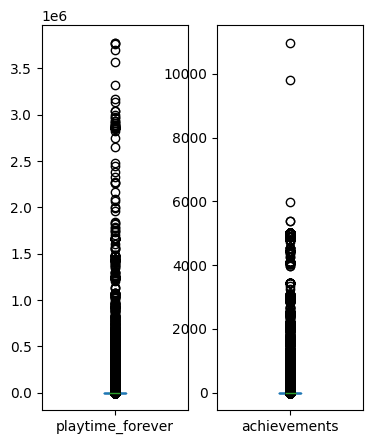

In [42]:
df[['playtime_forever', 'achievements']].plot(kind='box', subplots=True, layout=(1, len(df.columns)), figsize=(20, 5), notch=True)
plt.show()

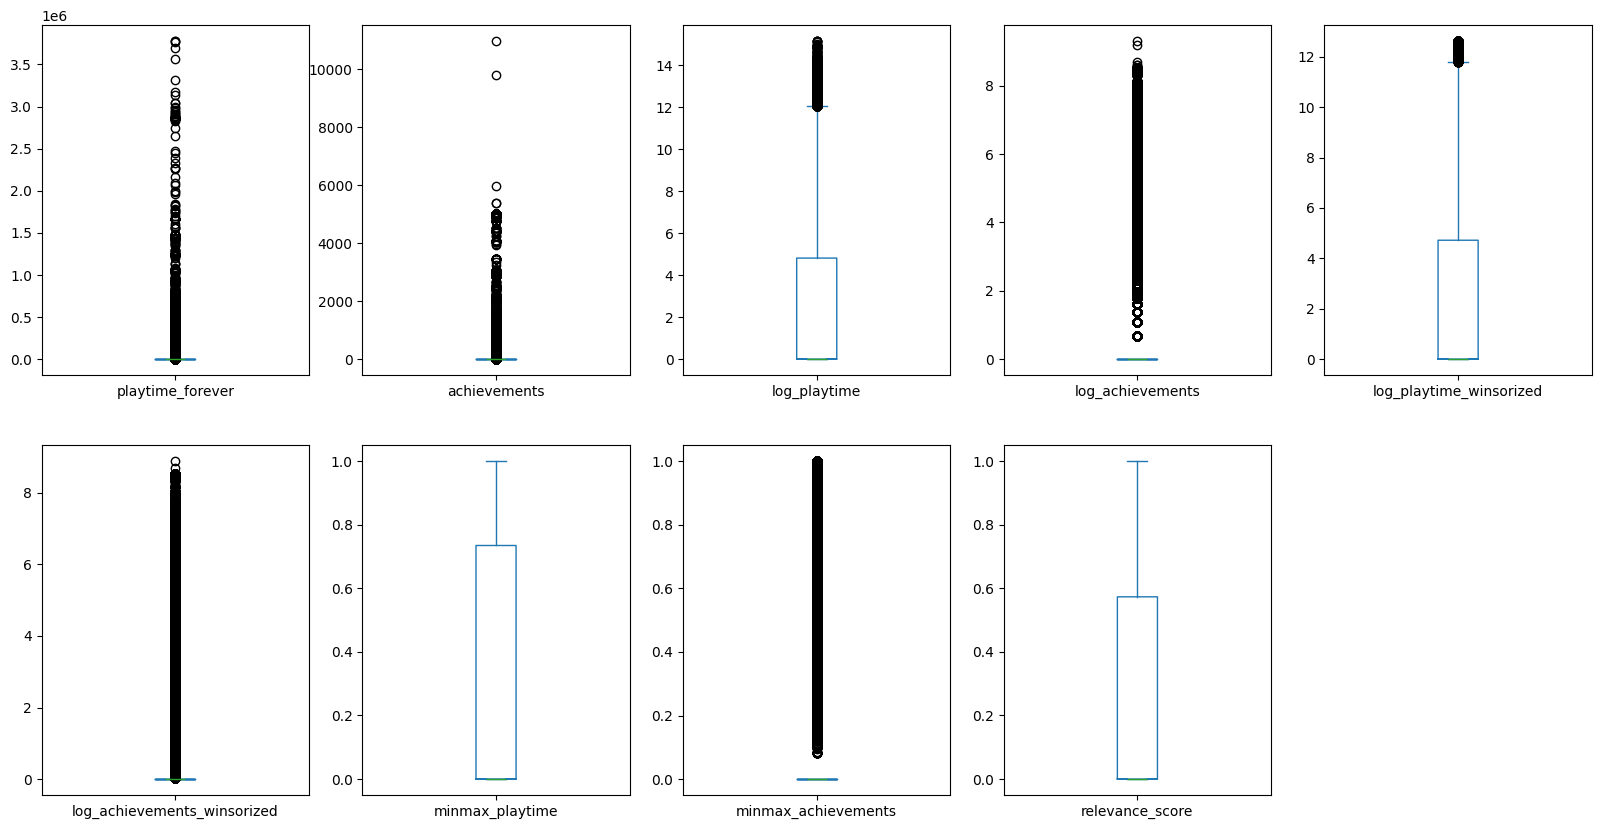

In [43]:
def compute_relevance_score(
    df_input,
    w1=0.7,  # Weight for playtime
    w2=0.3,  # Weight for achievements
    min_users_per_game=5  # Min users per game for normalization
):
    """
    Computes a per-game normalized 'relevance' score using log-transform and Min-Max scaling.
    If a game has no achievements, only playtime is used.
    """
    df = df_input.copy()

    # Fill missing achievements with 0
    df['achievements'] = df['achievements'].fillna(0)

    # Identify if a game actually has achievements available
    df['game_has_ach'] = df.groupby('app_id')['achievements'].transform(lambda x: x.max() > 0).astype(int)

    # Log-Transform Playtime & Achievements to Reduce Skew
    df['log_playtime'] = np.log1p(df['playtime_forever'])
    df['log_achievements'] = np.log1p(df['achievements'])

    # Clip extreme outliers
    def winsorize(series, lower=0.05, upper=0.95):
        """Clips values at given percentiles to limit extreme outliers."""
        q_low, q_high = series.quantile(lower), series.quantile(upper)
        return np.clip(series, q_low, q_high)

    df['log_playtime_winsorized'] = df.groupby('app_id')['log_playtime'].transform(winsorize)
    df['log_achievements_winsorized'] = df.groupby('app_id')['log_achievements'].transform(winsorize)

    # Per-Game Min-Max Scaling
    def min_max_scale(series):
        """Min-Max scales per game (0 to 1)."""
        min_val = series.min()
        max_val = series.max()
        return (series - min_val) / (max_val - min_val + 1e-6)  # Prevent division by zero

    df['minmax_playtime'] = df.groupby('app_id')['log_playtime_winsorized'].transform(
        lambda x: min_max_scale(x) if len(x) >= min_users_per_game else 0
    )
    df['minmax_achievements'] = df.groupby('app_id')['log_achievements_winsorized'].transform(
        lambda x: min_max_scale(x) if len(x) >= min_users_per_game else 0
    )

    # Compute final relevance score
    df['relevance_score'] = np.where(
        df['game_has_ach'] == 1,
        w1 * df['minmax_playtime'] + w2 * df['minmax_achievements'],  # Weighted sum if game has achievements
        df['minmax_playtime']  # Use only playtime otherwise
    )

    return df

df_relevance_score = compute_relevance_score(df)
df_relevance_score[['playtime_forever', 'achievements', 'log_playtime', 'log_achievements', 'log_playtime_winsorized', 'log_achievements_winsorized',
                    'minmax_playtime', 'minmax_achievements', 'relevance_score']].plot(kind='box', subplots=True, figsize=(20, 10), layout=(2, 5), notch=True)
plt.show()

Notes : In practice, most users do not pursue or unlock achievements, so it’s expected that the scaled achievements cluster near 0. Similarly, the key purpose of the relevance score is to identify standout engagement relative to most other cases. So, I believe it is acceptable for them to skew toward 0 which means that many user–game pairs involve minimal interaction and this is what we want the predictive model to see and learn from.

In [44]:
df_relevance_score.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3985828 entries, 0 to 3985827
Data columns (total 17 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   user_id                      3985828 non-null  object 
 1   app_id                       3985828 non-null  int64  
 2   playtime_forever             3985828 non-null  int64  
 3   timeCreated                  3985828 non-null  int64  
 4   achievements                 3985828 non-null  float64
 5   locCountryCode               3140942 non-null  object 
 6   locStateCode                 1940866 non-null  object 
 7   locCityID                    1124819 non-null  float64
 8   coordinates                  3075256 non-null  object 
 9   game_has_ach                 3985828 non-null  int64  
 10  log_playtime                 3985828 non-null  float64
 11  log_achievements             3985828 non-null  float64
 12  log_playtime_winsorized      3985828 non-n

In [ ]:
# Drop all intermediate column to prevent data leakage
df_relevance_score = df_relevance_score[['user_id', 'app_id', 'relevance_score', 'timeCreated',
                                         'locCountryCode', 'locStateCode', 'locCityID', 'coordinates']]

In [46]:
df_relevance_score.sample(5)

,user_id,app_id,relevance_score,timeCreated,locCountryCode,locStateCode,locCityID,coordinates
359840,76561198056039454,368230,0.000000,1325244881,BR,23,NaN,"-29.534505,-53.390607"
1352771,76561198025325404,730,0.461842,1273885892,BR,21,NaN,"-22.903539,-43.209587"
356387,76561198043585112,108800,0.000000,1308563527,HU,04,19623.0,"48.29394,20.693411"
3068745,76561197969548941,271590,0.901428,1097661660,NaN,NaN,NaN,None
779962,76561198415807053,1946300,0.000000,1503745684,VN,NaN,NaN,"14.058324,108.277199"


## User Metadata Cleaning

In [ ]:
df_relevance_score["has_coordinates"] = df_relevance_score["coordinates"].notnull().astype(bool)

def split_coordinates(coord):
    if pd.isnull(coord):
        return (None, None)
    try:
        lat, lon = map(float, coord.split(","))
        return lat, lon
    except:
        return (None, None)

df_relevance_score["latitude"], df_relevance_score["longitude"] = zip(*df_relevance_score["coordinates"].apply(split_coordinates))

df_relevance_score['locCountryCode'] = df_relevance_score['locCountryCode'].fillna('Missing')

In [ ]:
df_relevance_score['timeCreated'] = pd.to_numeric(df_relevance_score['timeCreated'], errors='coerce')
df_relevance_score['account_created'] = pd.to_datetime(df_relevance_score['timeCreated'], unit='s', errors='coerce')

# Calculate account age in months
df_relevance_score['account_age_months'] = (pd.Timestamp.now() - df_relevance_score['account_created']) / pd.Timedelta(days=30.44)
df_relevance_score['account_age_months'] = df_relevance_score['account_age_months'].astype(float)

In [49]:
df_relevance_score.drop(columns=['timeCreated', 'account_created', 'locStateCode', 'locCityID', 'coordinates'], inplace=True)

In [50]:
df_relevance_score.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3985828 entries, 0 to 3985827
Data columns (total 8 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   user_id             3985828 non-null  object 
 1   app_id              3985828 non-null  int64  
 2   relevance_score     3985828 non-null  float64
 3   locCountryCode      3985828 non-null  object 
 4   has_coordinates     3985828 non-null  bool   
 5   latitude            3075256 non-null  float64
 6   longitude           3075256 non-null  float64
 7   account_age_months  3985828 non-null  float64
dtypes: bool(1), float64(4), int64(1), object(2)
memory usage: 216.7+ MB


In [51]:
df_relevance_score.sample(5)

,user_id,app_id,relevance_score,locCountryCode,has_coordinates,latitude,longitude,account_age_months
1815165,76561198096392028,233530,0.670011,Missing,False,NaN,NaN,140.536398
2848462,76561198074261126,591360,0.999999,Missing,False,NaN,NaN,148.779545
591035,76561198005092460,296050,0.000000,RU,True,59.939524,30.312021,194.214427
2664477,76561198067136600,296470,0.388430,CA,True,56.130366,-106.346771,152.194707
808917,76561198056261703,952040,0.856151,US,True,37.090240,-95.712891,158.548834


latitude                 Axes(0.125,0.11;0.227941x0.77)
longitude             Axes(0.398529,0.11;0.227941x0.77)
account_age_months    Axes(0.672059,0.11;0.227941x0.77)
dtype: object

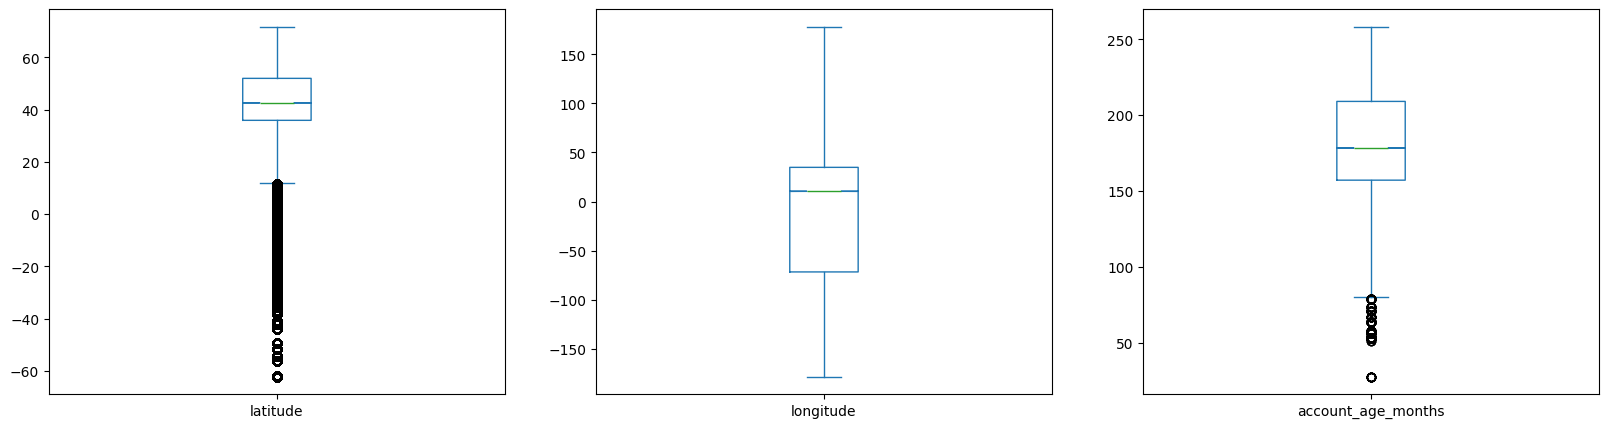

In [52]:
df_relevance_score[['latitude', 'longitude', 'account_age_months']].plot(kind='box', subplots=True, figsize=(20, 5), notch=True)

In [53]:
# check invalid location

df_relevance_score[
    (df_relevance_score["latitude"] < -90) | (df_relevance_score["latitude"] > 90) |
    (df_relevance_score["longitude"] < -180) | (df_relevance_score["longitude"] > 180)
]

,user_id,app_id,relevance_score,locCountryCode,has_coordinates,latitude,longitude,account_age_months


In [54]:
joblib.dump(df_relevance_score, r"..\..\assets\SteamWeb\steamWeb_processed.pkl")

['..\\..\\assets\\SteamWeb\\steamWeb_processed.pkl']